# Hierarchical Multi-class and Multi-label Text Classification for Crime Report: A Deep Learning Ensemble Analysis

## Prerequisites

In [1]:
import pandas as pd
import numpy as np
import gc
import re
import requests
import random
import torch
import time
import warnings
import nltk

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go
import plotly.io as pio
from matplotlib_venn import venn3
from upsetplot import from_contents, UpSet
from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords
from PIL import Image as PilImage
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report, f1_score
from scipy.stats import wilcoxon, rankdata
from math import sqrt

from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage
from IPython.display import Image, display, Markdown

from functools import partial
from typing import Literal, List
from pydantic import BaseModel, Field, ValidationError

from sentence_transformers import SentenceTransformer
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

from server.LLM_server import LLMServer
from server.generation_response import GenerationResponse

from transformers import logging
logging.set_verbosity_error()

from IPython.display import display
from tqdm import tqdm

tqdm.pandas()
pio.renderers.default = 'notebook'
warnings.simplefilter(action='ignore', category=FutureWarning)


MODEL = 'llama3.1'
SERVER_URL = "http://localhost:8053/v1/completions"
SERVER_VERIFICATION_URL = "http://localhost:8053/ready"
SERVER_TIMEOUT = 1000
SERVER_INTERVAL = 1
MAX_TOKENS = 100
TEMPERATURE = 0.7
MAX_RETRIES = 5
SEED = 12345

## Datasets Preparation

In [3]:
# Original dataset read
original = pd.read_csv('./Datasets/01_OriginalDataset.csv')
original.shape

(6533919, 2)

In [2]:
# Augmented is the original dataset after the following steps:
#    - Initial treatment of null values and other preprocessing
#    - Extraction of “never-seen-before” instances
#    - Insertion of labels according to the classification tree
augmented = pd.read_csv("./Datasets/05_AugmentedDataset.csv").drop_duplicates()
augmented.shape

(5204804, 4)

In [3]:
# Sampled is the dataset obtained by sampling from the augmented dataset.
# It was used to train and test the XGBoost model and should not be used for activities other than training.
sampled = pd.read_csv("./Datasets/06_SampledBalancedDataset.csv").drop_duplicates()
sampled.shape

(184959, 4)

In [4]:
# The goal here is to use the records from the augmented dataset that were left out due to sampling.
# I will merge these records with the "never seen before" subset because they were also not used in the first project.
diff = pd.concat([augmented, sampled]).drop_duplicates(keep=False)
diff.shape

(5019845, 4)

In [5]:
# Data that was never seen by the XGBoost models
never = pd.read_csv('./Datasets/02_NeverSeenBefore.csv')
print(never.shape)

dm = pd.read_csv('./Datasets/04_DomainHierarchy.csv')

never_augmented = pd.merge(never, dm, on='N3', how='left')
never_augmented = never_augmented[['DINAMICA', 'N1', 'N2', 'N3']].reset_index().drop(columns="index")
print(never_augmented.shape)

(276803, 2)
(276803, 4)


In [6]:
# Concatenating those records that were not used in the XGBoost with those that were never seen before.
df = pd.concat([diff, never_augmented])
df.shape

(5296648, 4)

In [12]:
# Saving the entire unseen dataset
df.to_csv('./Datasets/07_StartDataset.csv', index=False)

In [13]:
# Sampling 30 records from each of the classes in N3
amostra = df.groupby('N3').progress_apply(lambda group: group.sample(n=30, random_state=SEED)).reset_index(drop=True)
amostra.shape

 57%|████████████████████████▋                  | 46/80 [00:01<00:00, 42.43it/s]/home/andre/JupyterProjects/venv_doutorado/lib/python3.12/site-packages/tqdm/std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|███████████████████████████████████████████| 80/80 [00:01<00:00, 46.70it/s]


(2400, 4)

In [14]:
# Saving the sample dataset for the final evaluation of the method
amostra.to_csv('./Datasets/08_FinalSampledDataset.csv', index=False)

## Method Evaluation

In [2]:
# Loading the dataset with 30 samples per class prepared for the method evaluation
df = pd.read_csv('./Datasets/08_FinalSampledDataset.csv')
print(df.columns)
print(df.shape)

Index(['DINAMICA', 'N1', 'N2', 'N3'], dtype='object')
(2400, 4)


In [9]:
# Loading the classification tree
dm = pd.read_csv('./Datasets/04_DomainHierarchy.csv')
dm.head()

,N1,N2,N3
0,Crimes Contra Propriedade,Estelionato,Estelionato (outros)
1,Crimes Contra Propriedade,Estelionato,Estelionato (outros) - Tentativa
2,Crimes Contra Propriedade,Estelionato,Estelionato com Emprego de Cartão de Crédito
3,Crimes Contra Propriedade,Roubo,Roubo a Transeunte
4,Crimes Contra Propriedade,Roubo,Roubo de Veículo


In [6]:
# START NODE - STATES DEFINITIONS

# Overall State
class OverallState(TypedDict):
    input_dataset: pd.DataFrame
    llm_predictions_dataset: pd.DataFrame
    ml_predictions_dataset: pd.DataFrame
    classification_dataset: pd.DataFrame
    service: LLMServer

# Input State
class InputState(TypedDict):
    input_dataset: pd.DataFrame

# Output State
class OutputState(TypedDict):
    classification_dataset: pd.DataFrame

In [7]:
# PREPROCESSING NODE

# Auxiliary function
def generate_embedding(row, embedding_model, embedding_columns):
    embedding = embedding_model.encode(row['DINAMICA'], convert_to_tensor=False, normalize_embeddings=True)
    return pd.concat([row, pd.Series(embedding, index=embedding_columns)])


# Node function
def preprocessing(state: InputState) -> OutputState:
    print("NODE Preprocessing:")
    input_dataset = state['input_dataset']

    embedding_model = SentenceTransformer('intfloat/multilingual-e5-large-instruct')    
    embedding_columns = [f"Embedding_{i}" for i in range(1024)]
    input_dataset = input_dataset.progress_apply(generate_embedding, embedding_model=embedding_model, embedding_columns=embedding_columns, axis=1)
    
    ml_predictions_dataset = input_dataset[embedding_columns + ['N3']].copy()
    llm_predictions_dataset = input_dataset[['DINAMICA', 'N3']].copy()

    del input_dataset
    del embedding_model
    del embedding_columns
    gc.collect()
    torch.cuda.empty_cache()

    print("NODE Preprocessing: Concluded")
    
    return {
        'ml_predictions_dataset': ml_predictions_dataset,
        'llm_predictions_dataset': llm_predictions_dataset
    }

In [8]:
# TRADITIONAL MACHINE LEARNING - LEFT FLOW

# Auxiliary function - Load a XGBoost model in memory
def load_model(path):
    model = XGBClassifier()
    model.load_model(path)
    
    return model

# Auxiliary function - Load a XGBoost encoder
def read_encoder(path):
    encoder = LabelEncoder()
    encoder.classes_ = np.load(path, allow_pickle=True)
    
    return encoder

# Auxiliary dict - strucuture to storage models and encoders paths    
xgboost_model_db = {
    "N0_root": {
        "model": load_model("./Models/N0/root/root.model"),
        "encoder": read_encoder('./Models/N0/root/root.npy'),
    },
    "N1_Crimes Contra Pessoa": {
        "model": load_model("./Models/N1/Crimes Contra Pessoa/Crimes Contra Pessoa.model"),
        "encoder": read_encoder('./Models/N1/Crimes Contra Pessoa/Crimes Contra Pessoa.npy'),
    },
    "N1_Crimes Contra Propriedade": {
        "model": load_model("./Models/N1/Crimes Contra Propriedade/Crimes Contra Propriedade.model"),
        "encoder": read_encoder('./Models/N1/Crimes Contra Propriedade/Crimes Contra Propriedade.npy'),
    },
    "N1_Crimes de Trânsito ou Meio Ambiente": {
        "model": load_model("./Models/N1/Crimes de Trânsito ou Meio Ambiente/Crimes de Trânsito ou Meio Ambiente.model"),
        "encoder": read_encoder('./Models/N1/Crimes de Trânsito ou Meio Ambiente/Crimes de Trânsito ou Meio Ambiente.npy'),
    },
    "N1_Recuperação de Veículo ou Atos Administrativos ou Registro de Acontecimentos": {
        "model": load_model("./Models/N1/Recuperação de Veículo ou Atos Administrativos ou Registro de Acontecimentos/Recuperação de Veículo ou Atos Administrativos ou Registro de Acontecimentos.model"),
        "encoder": read_encoder('./Models/N1/Recuperação de Veículo ou Atos Administrativos ou Registro de Acontecimentos/Recuperação de Veículo ou Atos Administrativos ou Registro de Acontecimentos.npy'),
    },
    "N1_Relacionados a Drogas, Entorpecentes e Porte de Armas": {
        "model": load_model("./Models/N1/Relacionados a Drogas, Entorpecentes e Porte de Armas/Relacionados a Drogas, Entorpecentes e Porte de Armas.model"),
        "encoder": read_encoder('./Models/N1/Relacionados a Drogas, Entorpecentes e Porte de Armas/Relacionados a Drogas, Entorpecentes e Porte de Armas.npy'),
    },
    "N1_Resistência, Desacato ou Desobediência": {
        "model": load_model("./Models/N1/Resistência, Desacato ou Desobediência/Resistência, Desacato ou Desobediência.model"),
        "encoder": read_encoder('./Models/N1/Resistência, Desacato ou Desobediência/Resistência, Desacato ou Desobediência.npy'),
    },
    "N1_Violação ou Perturbação ou Dano ou Exercício Arbitrário": {
        "model": load_model("./Models/N1/Violação ou Perturbação ou Dano ou Exercício Arbitrário/Violação ou Perturbação ou Dano ou Exercício Arbitrário.model"),
        "encoder": read_encoder('./Models/N1/Violação ou Perturbação ou Dano ou Exercício Arbitrário/Violação ou Perturbação ou Dano ou Exercício Arbitrário.npy'),
    },
    "N2_Ameaça ou Injúria ou Perseguição ou Dano ou Extorsão": {
        "model": load_model("./Models/N2/Ameaça ou Injúria ou Perseguição ou Dano ou Extorsão/Ameaça ou Injúria ou Perseguição ou Dano ou Extorsão.model"),
        "encoder": read_encoder('./Models/N2/Ameaça ou Injúria ou Perseguição ou Dano ou Extorsão/Ameaça ou Injúria ou Perseguição ou Dano ou Extorsão.npy'),
    },
    "N2_Atos Administrativos": {
        "model": load_model("./Models/N2/Atos Administrativos/Atos Administrativos.model"),
        "encoder": read_encoder('./Models/N2/Atos Administrativos/Atos Administrativos.npy'),
    },
    "N2_Estelionato": {
        "model": load_model("./Models/N2/Estelionato/Estelionato.model"),
        "encoder": read_encoder('./Models/N2/Estelionato/Estelionato.npy'),
    },
    "N2_Estupro": {
        "model": load_model("./Models/N2/Estupro/Estupro.model"),
        "encoder": read_encoder('./Models/N2/Estupro/Estupro.npy'),
    },
    "N2_Furto": {
        "model": load_model("./Models/N2/Furto/Furto.model"),
        "encoder": read_encoder('./Models/N2/Furto/Furto.npy'),
    },
    "N2_Homicídio": {
        "model": load_model("./Models/N2/Homicídio/Homicídio.model"),
        "encoder": read_encoder('./Models/N2/Homicídio/Homicídio.npy'),
    },
    "N2_Lesão Corporal": {
        "model": load_model("./Models/N2/Lesão Corporal/Lesão Corporal.model"),
        "encoder": read_encoder('./Models/N2/Lesão Corporal/Lesão Corporal.npy'),
    },
    "N2_Recuperação de Veículo": {
        "model": load_model("./Models/N2/Recuperação de Veículo/Recuperação de Veículo.model"),
        "encoder": read_encoder('./Models/N2/Recuperação de Veículo/Recuperação de Veículo.npy'),
    },
    "N2_Registro de Um Acontecimento": {
        "model": load_model("./Models/N2/Registro de Um Acontecimento/Registro de Um Acontecimento.model"),
        "encoder": read_encoder('./Models/N2/Registro de Um Acontecimento/Registro de Um Acontecimento.npy'),
    },
    "N2_Roubo": {
        "model": load_model("./Models/N2/Roubo/Roubo.model"),
        "encoder": read_encoder('./Models/N2/Roubo/Roubo.npy'),
    },
}



# Node function - XGBoost prediction for N0
def ml_prediction_N0(state: OverallState) -> OverallState:
    print("NODE ML Prediction N0:")
    input_dataset = state['ml_predictions_dataset']

    X = input_dataset.drop(columns=['N3'], axis=1)
    pred = xgboost_model_db["N0_root"]["model"].predict(X)
    pred_proba = xgboost_model_db["N0_root"]["model"].predict_proba(X)

    maximos = []
    for i in range(len(pred_proba)):
        maximos.append(pred_proba[i][pred[i]])

    ml_predictions_dataset = input_dataset
    ml_predictions_dataset["N1_pred"] = xgboost_model_db["N0_root"]["encoder"].inverse_transform(pred)
    ml_predictions_dataset["N1_pred_proba"] = maximos

    print("NODE ML Prediction N0: Concluded")

    return {
        "ml_predictions_dataset": ml_predictions_dataset,
    }



# Auxiliary function - performs the prediction for a single row of the dataset for N1
def predict_row(row):
    model_name = "N1_" + row["N1_pred"]
    
    X = row.drop(labels=['N3', 'N1_pred', 'N1_pred_proba'])
    X = X.values.reshape(1, -1)
    
    pred = xgboost_model_db[model_name]["model"].predict(X)
    pred_proba = max(xgboost_model_db[model_name]["model"].predict_proba(X)[0])

    row["N2_pred"] = xgboost_model_db[model_name]["encoder"].inverse_transform(pred)[0]
    row["N2_pred_proba"] = pred_proba

    return row

# Node function - XGBoost prediction at N1
def ml_prediction_N1(state: OverallState) -> OverallState:
    print("NODE ML Prediction N1:")
    ml_predictions_dataset = state['ml_predictions_dataset']

    ml_predictions_dataset = ml_predictions_dataset.progress_apply(predict_row, axis=1)
    print("NODE ML Prediction N1: Concluded")

    return {
        "ml_predictions_dataset": ml_predictions_dataset
    }



# Auxiliary function - performs the prediction for a single row of the dataset for N2
def predict_row_n2(row):
    model_name = "N2_" + row["N2_pred"]
    if model_name in xgboost_model_db.keys():    
        X = row.drop(labels=['N3', 'N1_pred', 'N1_pred_proba', 'N2_pred', 'N2_pred_proba'])
        X = X.values.reshape(1, -1)
        
        pred = xgboost_model_db[model_name]["model"].predict(X)
        pred_proba = max(xgboost_model_db[model_name]["model"].predict_proba(X)[0])
    
        row["N3_pred"] = xgboost_model_db[model_name]["encoder"].inverse_transform(pred)[0]
        row["N3_pred_proba"] = pred_proba
    else:
        row["N3_pred"] = row["N2_pred"]
        row["N3_pred_proba"] = 1

    return row

# Node function - XGBoost prediction at N2
def ml_prediction_N2(state: OverallState) -> OverallState:
    print("NODE ML Prediction N2:")
    ml_predictions_dataset = state["ml_predictions_dataset"].progress_apply(predict_row_n2, axis=1)
    print("NODE ML Prediction N2: Concluded")

    return {
        "ml_predictions_dataset": ml_predictions_dataset
    }

In [10]:
# DEEP LEARNING - RIGHT FLOW

# Function to starts the llm server
def start_llm_server(state: OverallState) -> OverallState:
    service = LLMServer()
    service.start()

    return {
        'service': service
    }

# Function to stop the llm server
def stop_llm_server(state: OverallState) -> OverallState:
    service = state['service']
    service.stop()

# Auxiliary function - performs the prediction for a single row of the dataset
def row_llm_prediction(row, model_name='llama', column_name='column', classes=None):
    # Se não passou a lista de classes é pq estou prevendo no N2 ou N3
    # Preciso pegar a lista a partir do que já foi predito antes
    prob_name = f'N1 {model_name} Pred Proba'
    if classes is None: 
        if column_name == f'N2 {model_name} Classification':
            prob_name = f'N2 {model_name} Pred Proba'
            title = f'N1 {model_name} Classification'
            classes = dm[dm['N1'] == row[title]]['N2'].unique()
        elif column_name == f'N3 {model_name} Classification':
            prob_name = f'N3 {model_name} Pred Proba'
            title = f'N2 {model_name} Classification'
            classes = dm[dm['N2'] == row[title]]['N3'].unique()
        

    counter = 0
    data = None
    while not data and counter <= MAX_RETRIES:
        counter += 1
        request_id = random.randint(0, 100_000_000)

        messages=[
            {
                'role': 'system',
                'content': (
                    f"Você é um inspetor de polícia da Polícia Civil do Estado do Rio de Janeiro.\n"
                    f"Você é especialista no código penal brasileiro e em classificação de narrativas em tipos de delitos.\n"
                    f"Será provido para você narrativas de crimes ocorridos e você deve classificá-las em uma das classes providas.\n"
                )
            },
            {
                'role': 'user',
                'content': (
                    f"Responda a instrução a seguir em formato JSON."
                    'Exemplo de resposta:\n{\n"delito": "..."\n}\n\n'
                    f"Classifique a seguinte narrativa em um dos tipos de delitos providos a seguir:\n\n"
                    f"NARRATIVA: {row['DINAMICA']}\n\n"
                    f"TIPOS DE DELITOS:\n{classes}\n\n"
                    f"A sua resposta deve ser em formato JSON com um campo chamado 'delito' com o valor da classificação."
                )
            }
        ]
        
        payload = {
            "request_id": request_id,
            "prompt": messages,
            "max_tokens": MAX_TOKENS,
            "temperature": TEMPERATURE,
            "model": model_name
        }
        
        response = requests.post(SERVER_URL, json=payload)

        # Valida que o servidor respondeu com sucesso e que é o meu json correto da API
        if response.status_code == 200:
            try:
                data = GenerationResponse(**response.json())

                # Valida que essa é a resposta dessa requisição
                if request_id != data.response_id:
                    print("NODE: LLM Row Prediction - bad response id")
                    data = None

                # Se já veio assim do servidor é pq o servidor já tentou MAX_RETRIES lá e deu zebra e é melhor parar de tentar
                # Após sair desse if, ele entra no próximo pq a data.classification não estará entre uma das classes possíveis
                if data.classification == 'Sem Classificação':
                    count = MAX_RETRIES

                # Valida que o LLM respondeu uma das classes disponíveis para ele
                if data.classification not in classes:
                    print(f"NODE: LLM Row Prediction - bad classification - {model_name}")
                    data = None
                    row[column_name] = 'Sem Classificação'
                    row[prob_name] = 0

                # Já realizou todas as validações, logo posso atribuir aos valores da linha
                if data:
                    row[column_name] = data.classification
                    row[prob_name] = data.class_prob
                    
            except ValidationError as error:
                print("NODE: LLM Row Prediction - bad json")
                data = None
        else:
            print(f"{response.status_code} -> {response.text}")
            data = None        
            
    return row
    

#  Node function - LLM prediction for N1, N2 and N3, using pre-trained Llama and fine-tuned Llama
def llm_prediction(state: OverallState) -> OverallState:
    print("NODE LLM Prediction:")

    print("Aguardando servidor iniciar")
    server_ok = False
    start_time = time.time()
    while time.time() - start_time < SERVER_TIMEOUT and not server_ok:
        try:
            response = requests.get(SERVER_VERIFICATION_URL)
            if response.status_code == 200:
                print("Servidor está pronto.")
                server_ok = True
        except requests.exceptions.ConnectionError:
            print(".", end="")
            time.sleep(SERVER_INTERVAL)
    
    if server_ok:
        input_dataset = state['llm_predictions_dataset']
        input_dataset = input_dataset.progress_apply(row_llm_prediction, axis=1, model_name='llama', column_name='N1 llama Classification', classes=dm['N1'].unique())
        input_dataset = input_dataset.progress_apply(row_llm_prediction, axis=1, model_name='llama', column_name='N2 llama Classification')
        input_dataset = input_dataset.progress_apply(row_llm_prediction, axis=1, model_name='llama', column_name='N3 llama Classification')

        input_dataset = input_dataset.progress_apply(row_llm_prediction, axis=1, model_name='fine_llama', column_name='N1 fine_llama Classification', classes=dm['N1'].unique())
        input_dataset = input_dataset.progress_apply(row_llm_prediction, axis=1, model_name='fine_llama', column_name='N2 fine_llama Classification')
        input_dataset = input_dataset.progress_apply(row_llm_prediction, axis=1, model_name='fine_llama', column_name='N3 fine_llama Classification')
        print("NODE LLM Prediction: Concluded")
    else:
        print("NODE LLM Prediction: Skipping. Server not OK!")
    
    return {
        "llm_predictions_dataset": input_dataset,
    }

In [20]:
# POSTPROCESSING NODE

# Auxiliary function - add correct N1, N2, and N3 labels
def get_n_labels(row):
    row['Label_N1'], row['Label_N2'], row['Label_N3'] = dm[dm['N3'] == row['Label']].values[0]

    return row

# Node function
def postprocessing(state: OverallState) -> OutputState:
    print("NODE Postprocessing:")
    llm_predictions_dataset = state['llm_predictions_dataset']
    llm_predictions_dataset['Llama Final Prediction Proba'] = llm_predictions_dataset['N1 llama Pred Proba'] * llm_predictions_dataset['N2 llama Pred Proba'] * llm_predictions_dataset['N3 llama Pred Proba']
    llm_predictions_dataset['Fine Llama Final Prediction Proba'] = llm_predictions_dataset['N1 fine_llama Pred Proba'] * llm_predictions_dataset['N2 fine_llama Pred Proba'] * llm_predictions_dataset['N3 fine_llama Pred Proba']
    
    ml_predictions_dataset = state['ml_predictions_dataset']
    ml_predictions_dataset = ml_predictions_dataset.rename(columns={
        'N1_pred': 'N1 ML Classification',
        'N1_pred_proba': 'N1 Pred Proba',
        'N2_pred': 'N2 ML Classification',
        'N2_pred_proba': 'N2 Pred Proba',
        'N3_pred': 'N3 ML Classification',
        'N3_pred_proba': 'N3 Pred Proba',
    })
    ml_predictions_dataset['ML Final Prediction Proba'] = ml_predictions_dataset['N1 Pred Proba'] * ml_predictions_dataset['N2 Pred Proba'] * ml_predictions_dataset['N3 Pred Proba']

    classification_dataset = pd.concat(
        [
            llm_predictions_dataset[[
                'N3', 
                'DINAMICA', 
                'N1 llama Classification', 'N1 llama Pred Proba', 
                'N2 llama Classification', 'N2 llama Pred Proba', 
                'N3 llama Classification', 'N3 llama Pred Proba',
                'Llama Final Prediction Proba',
                'N1 fine_llama Classification', 'N1 fine_llama Pred Proba', 
                'N2 fine_llama Classification', 'N2 fine_llama Pred Proba', 
                'N3 fine_llama Classification', 'N3 fine_llama Pred Proba',
                'Fine Llama Final Prediction Proba'
            ]], 
            ml_predictions_dataset[[
                'N1 ML Classification', 'N1 Pred Proba', 
                'N2 ML Classification', 'N2 Pred Proba', 
                'N3 ML Classification', 'N3 Pred Proba', 
                'ML Final Prediction Proba'
            ]]
        ], 
        axis=1
    )

    classification_dataset = classification_dataset.rename(columns={'N3': 'Label'})
    classification_dataset = classification_dataset.progress_apply(get_n_labels, axis=1)
    
    print("NODE Postprocessing: Concluded")
    
    return {
        'classification_dataset': classification_dataset.copy()
    }

In [7]:
# REVIEWER NODE

# Auxiliary function - performs ensemble scenarios
def joint_venture(row): 
    fine_prob = row['Fine Llama Final Prediction Proba']
    llama_prob = row['Llama Final Prediction Proba']
    ml_prob = row['ML Final Prediction Proba']

    # All models together
    if fine_prob >= llama_prob and proba1 >= proba3:
        row['Joint Classification'] = row['N3 fine_llama Classification']
    elif llama_prob > fine_prob and proba2 >= proba3:
        row['Joint Classification'] = row['N3 llama Classification']
    elif ml_prob > fine_prob and proba3 > proba2:
        row['Joint Classification'] = row['N3 ML Classification']

    # XGBoost + pre-trained Llama
    if llama_prob >= ml_prob:
        row['ML + Llama'] = row['N3 llama Classification']
    else:
        row['ML + Llama'] = row['N3 ML Classification']

    # XGBoost + fine-tuned Llama
    if fine_prob >= ml_prob:
        row['ML + Fine Llama'] = row['N3 fine_llama Classification']
    else:
        row['ML + Fine Llama'] = row['N3 ML Classification']

    # Pre-trained Llama + fine-tuned Llama
    if fine_prob >= llama_prob:        
        row['Llama + Fine Llama'] = row['N3 fine_llama Classification']
    else:
        row['Llama + Fine Llama'] = row['N3 llama Classification']
        
    return row
    

# Node function
def reviewer(state: OutputState) -> OutputState:
    print("NODE Reviewer:")
    classification_dataset = state['classification_dataset']
    classification_dataset = classification_dataset.progress_apply(joint_venture, axis=1)
    print("NODE Reviewer: Concluded")

    return {
        "classification_dataset": classification_dataset
    }

In [13]:
# Graph Creation

# States
builder = StateGraph(OverallState, input_schema=InputState, output_schema=OutputState)

# Nodes
builder.add_node("Preprocessing", preprocessing)
builder.add_node("Start LLM Server", start_llm_server)
builder.add_node("LLM Prediction", llm_prediction)
builder.add_node("Stop LLM Server", stop_llm_server)
builder.add_node("ML Prediction N0", ml_prediction_N0)
builder.add_node("ML Prediction N1", ml_prediction_N1)
builder.add_node("ML Prediction N2", ml_prediction_N2)
builder.add_node("Post Processing", postprocessing)
builder.add_node("Reviewer", reviewer)

# Edges
builder.add_edge(START, "Preprocessing")
builder.add_edge("Preprocessing", "Start LLM Server")
builder.add_edge("Preprocessing", "ML Prediction N0")
builder.add_edge("Start LLM Server", "LLM Prediction")
builder.add_edge("LLM Prediction", "Stop LLM Server")
builder.add_edge("ML Prediction N0", "ML Prediction N1")
builder.add_edge("ML Prediction N1", "ML Prediction N2")
builder.add_edge(["Stop LLM Server", "ML Prediction N2"], "Post Processing")
builder.add_edge("Post Processing", "Reviewer")
builder.add_edge("Reviewer", END)

# Compile
graph = builder.compile()

# View
# Since I'm using a dark theme, I need to configure a color scheme to work properly.
mermaid_start = """```mermaid
---
config:
  flowchart:
    curve: linear
---
%%{
  init: {
    'theme': 'base',
    "flowchart" : { "curve" : "basis" },
    'themeVariables': {
      'primaryColor': '#00a9ad',
      'primaryTextColor': '#222',
      'primaryBorderColor': '#EEE',
      'lineColor': '#EEE',
      'secondaryColor': '#0048e4',
      'tertiaryColor': '#0200ff'
    }
  }
}%%
"""
mermaid_end = "\n```"

# Retrieving the graph content and adapting it to my own dark-theme style
content = "".join(re.findall(r'(graph TD;.*?__end__;)', graph.get_graph().draw_mermaid(), re.DOTALL))    
display(Markdown(mermaid_start + content + mermaid_end))

```mermaid
---
config:
  flowchart:
    curve: linear
---
%%{
  init: {
    'theme': 'base',
    "flowchart" : { "curve" : "basis" },
    'themeVariables': {
      'primaryColor': '#00a9ad',
      'primaryTextColor': '#222',
      'primaryBorderColor': '#EEE',
      'lineColor': '#EEE',
      'secondaryColor': '#0048e4',
      'tertiaryColor': '#0200ff'
    }
  }
}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	Preprocessing(Preprocessing)
	Start_LLM_Server(Start LLM Server)
	LLM_Prediction(LLM Prediction)
	Stop_LLM_Server(Stop LLM Server)
	ML_Prediction_N0(ML Prediction N0)
	ML_Prediction_N1(ML Prediction N1)
	ML_Prediction_N2(ML Prediction N2)
	Post_Processing(Post Processing)
	Reviewer(Reviewer)
	__end__([<p>__end__</p>]):::last
	LLM_Prediction --> Stop_LLM_Server;
	ML_Prediction_N0 --> ML_Prediction_N1;
	ML_Prediction_N1 --> ML_Prediction_N2;
	ML_Prediction_N2 --> Post_Processing;
	Post_Processing --> Reviewer;
	Preprocessing --> ML_Prediction_N0;
	Preprocessing --> Start_LLM_Server;
	Start_LLM_Server --> LLM_Prediction;
	Stop_LLM_Server --> Post_Processing;
	__start__ --> Preprocessing;
	Reviewer --> __end__;
```

In [15]:
input_message = {"input_dataset": df}

start = time.time()
answer = graph.invoke(input_message)
time.time() - start

NODE Preprocessing:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.17it/s]


NODE Preprocessing: Concluded
NODE ML Prediction N0:
NODE ML Prediction N0: Concluded
NODE LLM Prediction:
Aguardando servidor iniciar
NODE ML Prediction N1:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 365.09it/s]

.LLAMA
Llama: Realizando login no Hugging Faces
NODE ML Prediction N1: Concluded
Llama: Configurando bits and bytes
Llama: Carregando tokenizador


.Llama: Carregando modelo na VRAM


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

.........Llama: Pronto!
Fine Llama
Fine Tuned Llama: Configurando bits and bytes
Fine Tuned Llama: Carregando tokenizador
Llama: Carregando modelo na VRAM


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

........Fine Tuned Llama: Pronto!
Eu to pronto, cara! Fala comigo
Servidor está pronto.


 40%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 4/10 [00:02<00:03,  1.86it/s]

NODE: LLM Row Prediction - bad classification - llama


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 9/10 [00:04<00:00,  1.75it/s]

NODE: LLM Row Prediction - bad classification - llama
NODE: LLM Row Prediction - bad classification - llama
NODE: LLM Row Prediction - bad classification - llama
NODE: LLM Row Prediction - bad classification - llama
NODE: LLM Row Prediction - bad classification - llama


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.15s/it]

NODE: LLM Row Prediction - bad classification - llama


 40%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 4/10 [00:01<00:02,  2.23it/s]

NODE: LLM Row Prediction - bad classification - llama


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 8/10 [00:05<00:01,  1.33it/s]

NODE: LLM Row Prediction - bad classification - llama


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 9/10 [00:06<00:00,  1.21it/s]

NODE: LLM Row Prediction - bad classification - llama
NODE: LLM Row Prediction - bad classification - llama
NODE: LLM Row Prediction - bad classification - llama
NODE: LLM Row Prediction - bad classification - llama
NODE: LLM Row Prediction - bad classification - llama


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.86s/it]

NODE: LLM Row Prediction - bad classification - llama


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.45s/it]


NODE LLM Prediction: Concluded
NODE ML Prediction N2:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 48.42it/s]


NODE ML Prediction N2: Concluded
NODE Postprocessing:
NODE Postprocessing: Concluded
NODE Reviewer:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3361.09it/s]

NODE Reviewer: Concluded


152.79024600982666

In [24]:
answer['classification_dataset'].to_csv('./Datasets/09_Results.csv', index=False)

## Results Analysis

### Result Dataset Read

In [4]:
data = pd.read_csv("./Datasets/09_Results.csv")
print(data.columns)
print(data.shape)

Index(['Label', 'DINAMICA', 'N1 llama Classification', 'N1 llama Pred Proba',
       'N2 llama Classification', 'N2 llama Pred Proba',
       'N3 llama Classification', 'N3 llama Pred Proba',
       'Llama Final Prediction Proba', 'N1 fine_llama Classification',
       'N1 fine_llama Pred Proba', 'N2 fine_llama Classification',
       'N2 fine_llama Pred Proba', 'N3 fine_llama Classification',
       'N3 fine_llama Pred Proba', 'Fine Llama Final Prediction Proba',
       'N1 ML Classification', 'N1 Pred Proba', 'N2 ML Classification',
       'N2 Pred Proba', 'N3 ML Classification', 'N3 Pred Proba',
       'ML Final Prediction Proba', 'Joint Classification', 'ML + Llama',
       'ML + Fine Llama', 'Llama + Fine Llama', 'Label_N1', 'Label_N2',
       'Label_N3'],
      dtype='object')
(2400, 30)


### Checking the Records that Remained Unclassified

In [8]:
# Records that remained unclassified by the XGBoost model at levels N1, N2, and N3, respectively.
display(data[data['N1 ML Classification'] == 'Sem Classificação'].shape)
display(data[data['N2 ML Classification'] == 'Sem Classificação'].shape)
display(data[data['N3 ML Classification'] == 'Sem Classificação'].shape)

(0, 30)

(0, 30)

(0, 30)

In [9]:
# Records that remained unclassified by the pre-trained Llama model at levels N1, N2, and N3, respectively.
display(data[data['N1 llama Classification'] == 'Sem Classificação'].shape)
display(data[data['N2 llama Classification'] == 'Sem Classificação'].shape)
display(data[data['N3 llama Classification'] == 'Sem Classificação'].shape)

(3, 30)

(73, 30)

(197, 30)

In [10]:
# Records that remained unclassified by the fine-tuned Llama model at levels N1, N2, and N3, respectively.
display(data[data['N1 fine_llama Classification'] == 'Sem Classificação'].shape)
display(data[data['N2 fine_llama Classification'] == 'Sem Classificação'].shape)
display(data[data['N3 fine_llama Classification'] == 'Sem Classificação'].shape)

(0, 30)

(0, 30)

(0, 30)

### Accuracy

In [12]:
total = data.shape[0]
ml = (data['Label'] == data['N3 ML Classification']).sum()
llama = (data['Label'] == data['N3 llama Classification']).sum()
fine_llama = (data['Label'] == data['N3 fine_llama Classification']).sum()
ml_llama = (data['Label'] == data['ML + Llama']).sum()
ml_fine_llama = (data['Label'] == data['ML + Fine Llama']).sum()
llama_fine_llama = (data['Label'] == data['Llama + Fine Llama']).sum()
joint = (data['Label'] == data['Joint Classification']).sum()

acuracias = {
    'Métrica': [
        'XGBoost', 
        'Llama',
        'Fine Llama',
        'XGBoost + Llama',
        'XGBoost + Fine Llama',
        'Llama + Fine Llama',
        'Todos'
    ],
    'Valor': [
        ml/total,
        llama/total,
        fine_llama/total,
        ml_llama/total,
        ml_fine_llama/total,
        llama_fine_llama/total,
        joint/total
    ]
    
}
df_acuracias = pd.DataFrame(acuracias)
df_acuracias

,Métrica,Valor
0,XGBoost,0.564167
1,Llama,0.264167
2,Fine Llama,0.629583
3,XGBoost + Llama,0.527917
4,XGBoost + Fine Llama,0.623333
5,Llama + Fine Llama,0.538750
6,Todos,0.595000


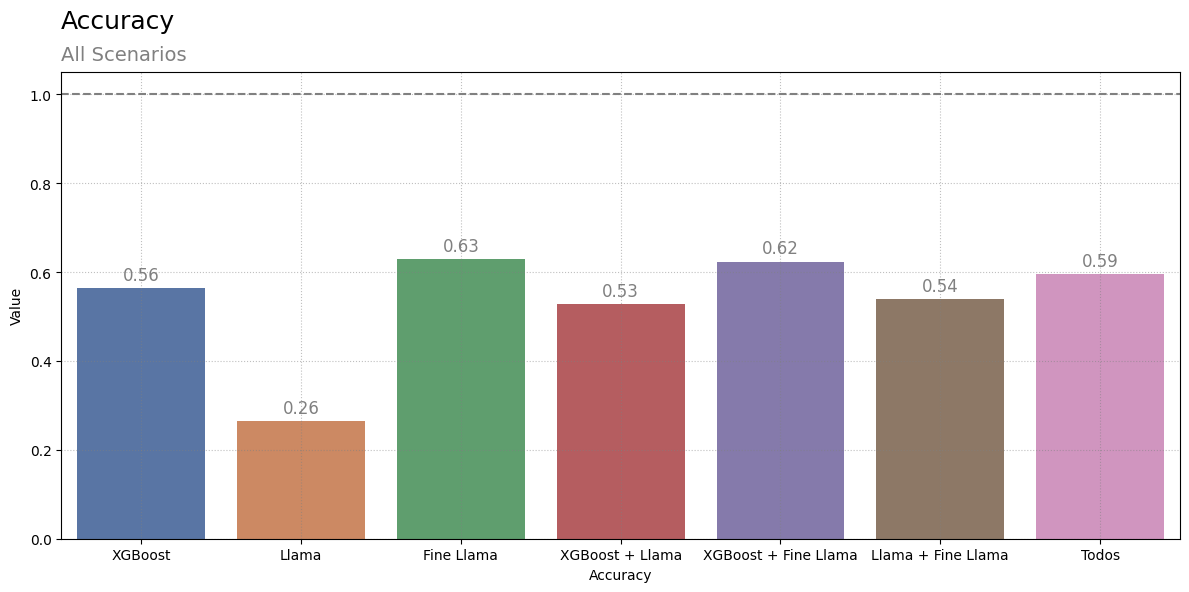

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=df_acuracias, x='Métrica', y='Valor', palette='deep', hue='Métrica', legend=False)
plt.axhline(y=1, linestyle='--', color='gray', linewidth=1.5)

for bar in ax.containers:
    ax.bar_label(bar, fmt='%.2f', padding=3, fontsize=12, color='gray')

plt.tight_layout(rect=[0, 0, 1, 0.9])
bbox = ax.get_position()
fig.text(bbox.x0, 0.98, 'Accuracy', fontsize=18, color='black', ha='left', va='top')
fig.text(bbox.x0, 0.92, 'All Scenarios', fontsize=14, color='gray', ha='left', va='top')


plt.xlabel('Accuracy')
plt.ylabel('Value')
# plt.xticks(rotation=90) 
# ax.set_yticks(np.arange(ymin, ymax, step))
ax.grid(True, color='gray', linestyle=':', alpha=0.5, zorder=0)
plt.show()

### F1-Score

In [14]:
print(f"XGBoost: {f1_score(data['Label'], data['N3 ML Classification'], average="weighted")}")
print(f"Pre-trained Llama: {f1_score(data['Label'], data['N3 llama Classification'], average="weighted")}")
print(f"Fine-tuned Llama: {f1_score(data['Label'], data['N3 fine_llama Classification'], average="weighted")}")
print(f"XGBoost + Pre-trained Llama: {f1_score(data['Label'], data['ML + Llama'], average="weighted")}")
print(f"XGBoost + Fine-tuned Llama: {f1_score(data['Label'], data['ML + Fine Llama'], average="weighted")}")
print(f"Pre-trained Llama + Fine-tuned Llama: {f1_score(data['Label'], data['Llama + Fine Llama'], average="weighted")}")
print(f"XGBoost + Pre-trained Llama + Fine-tuned Llama: {f1_score(data['Label'], data['Joint Classification'], average="weighted")}")

XGBoost: 0.5522698301554898
Pre-trained Llama: 0.23995379580868445
Fine-tuned Llama: 0.616909373545285
XGBoost + Pre-trained Llama: 0.5106323436846797
XGBoost + Fine-tuned Llama: 0.6099459132918824
Pre-trained Llama + Fine-tuned Llama: 0.5233148934696885
XGBoost + Pre-trained Llama + Fine-tuned Llama: 0.5761550465873014


In [15]:
print("XGBoost:")
print(classification_report(data['Label'], data['N3 ML Classification']))

XGBoost:
                                                                      precision    recall  f1-score   support

             Adulteração de Sinal Identificador de Veículo Automotor       0.58      0.73      0.65        30
                                                              Ameaça       0.31      0.17      0.22        30
                                                  Apreensão (outros)       0.57      0.13      0.22        30
Apreensão de Adolescente Infrator (Artigo 104 e 107 da Lei 8.069/90)       0.88      0.93      0.90        30
                                Apreensão de Substância Entorpecente       0.69      0.83      0.76        30
                                                Apreensão de Veículo       0.85      0.37      0.51        30
                                       Apropriação Indébita (outros)       0.43      0.77      0.55        30
                    Associação para Tráfico de Droga (Lei 11.343/06)       0.28      0.30      0.29        30


In [16]:
print("Pre-trained Llama:")
print(classification_report(data['Label'], data['N3 llama Classification']))

Pre-trained Llama:
                                                                      precision    recall  f1-score   support

             Adulteração de Sinal Identificador de Veículo Automotor       0.12      0.07      0.09        30
                                                              Ameaça       0.25      0.47      0.33        30
                                                  Apreensão (outros)       0.07      0.03      0.05        30
Apreensão de Adolescente Infrator (Artigo 104 e 107 da Lei 8.069/90)       1.00      0.23      0.38        30
                                Apreensão de Substância Entorpecente       0.41      0.90      0.56        30
                                                Apreensão de Veículo       0.00      0.00      0.00        30
                                       Apropriação Indébita (outros)       0.22      0.37      0.28        30
                    Associação para Tráfico de Droga (Lei 11.343/06)       0.33      0.07      0.11 

/home/andre/JupyterProjects/venv_doutorado/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/andre/JupyterProjects/venv_doutorado/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/home/andre/JupyterProjects/venv_doutorado/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/andre/JupyterProjects/venv_doutorado/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set 

In [17]:
print("Fine-tuned Llama:")
print(classification_report(data['Label'], data['N3 fine_llama Classification']))

Fine-tuned Llama:
                                                                      precision    recall  f1-score   support

             Adulteração de Sinal Identificador de Veículo Automotor       0.70      0.77      0.73        30
                                                              Ameaça       0.45      0.17      0.24        30
                                                  Apreensão (outros)       0.79      0.50      0.61        30
Apreensão de Adolescente Infrator (Artigo 104 e 107 da Lei 8.069/90)       1.00      0.93      0.97        30
                                Apreensão de Substância Entorpecente       0.71      0.97      0.82        30
                                                Apreensão de Veículo       0.77      0.57      0.65        30
                                       Apropriação Indébita (outros)       0.58      0.97      0.72        30
                    Associação para Tráfico de Droga (Lei 11.343/06)       0.16      0.17      0.16  

In [18]:
print("XGBoost + Pre-trained Llama:")
print(classification_report(data['Label'], data['ML + Llama']))

XGBoost + Pre-trained Llama:
                                                                      precision    recall  f1-score   support

             Adulteração de Sinal Identificador de Veículo Automotor       0.63      0.73      0.68        30
                                                              Ameaça       0.38      0.50      0.43        30
                                                  Apreensão (outros)       0.50      0.10      0.17        30
Apreensão de Adolescente Infrator (Artigo 104 e 107 da Lei 8.069/90)       0.90      0.90      0.90        30
                                Apreensão de Substância Entorpecente       0.59      0.90      0.71        30
                                                Apreensão de Veículo       0.91      0.33      0.49        30
                                       Apropriação Indébita (outros)       0.52      0.77      0.62        30
                    Associação para Tráfico de Droga (Lei 11.343/06)       0.27      0.13 

In [19]:
print("XGBoost + Fine-tuned Llama:")
print(classification_report(data['Label'], data['ML + Fine Llama']))

XGBoost + Fine-tuned Llama:
                                                                      precision    recall  f1-score   support

             Adulteração de Sinal Identificador de Veículo Automotor       0.67      0.80      0.73        30
                                                              Ameaça       0.55      0.20      0.29        30
                                                  Apreensão (outros)       0.89      0.27      0.41        30
Apreensão de Adolescente Infrator (Artigo 104 e 107 da Lei 8.069/90)       0.93      0.93      0.93        30
                                Apreensão de Substância Entorpecente       0.71      0.97      0.82        30
                                                Apreensão de Veículo       0.83      0.50      0.62        30
                                       Apropriação Indébita (outros)       0.49      0.87      0.63        30
                    Associação para Tráfico de Droga (Lei 11.343/06)       0.29      0.30  

In [20]:
print("Pre-trained Llama + Fine-tuned Llama:")
print(classification_report(data['Label'], data['Llama + Fine Llama']))

Pre-trained Llama + Fine-tuned Llama:
                                                                      precision    recall  f1-score   support

             Adulteração de Sinal Identificador de Veículo Automotor       0.73      0.73      0.73        30
                                                              Ameaça       0.37      0.50      0.42        30
                                                  Apreensão (outros)       1.00      0.37      0.54        30
Apreensão de Adolescente Infrator (Artigo 104 e 107 da Lei 8.069/90)       1.00      0.87      0.93        30
                                Apreensão de Substância Entorpecente       0.46      0.93      0.62        30
                                                Apreensão de Veículo       0.93      0.47      0.62        30
                                       Apropriação Indébita (outros)       0.45      0.83      0.58        30
                    Associação para Tráfico de Droga (Lei 11.343/06)       0.17  

/home/andre/JupyterProjects/venv_doutorado/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/andre/JupyterProjects/venv_doutorado/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/andre/JupyterProjects/venv_doutorado/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [21]:
print("XGBoost + Pre-trained Llama + Fine-tuned Llama:")
print(classification_report(data['Label'], data['Joint Classification']))

XGBoost + Pre-trained Llama + Fine-tuned Llama:
                                                                      precision    recall  f1-score   support

             Adulteração de Sinal Identificador de Veículo Automotor       0.69      0.80      0.74        30
                                                              Ameaça       0.47      0.50      0.48        30
                                                  Apreensão (outros)       0.88      0.23      0.37        30
Apreensão de Adolescente Infrator (Artigo 104 e 107 da Lei 8.069/90)       0.93      0.93      0.93        30
                                Apreensão de Substância Entorpecente       0.62      0.97      0.75        30
                                                Apreensão de Veículo       0.88      0.47      0.61        30
                                       Apropriação Indébita (outros)       0.57      0.87      0.68        30
                    Associação para Tráfico de Droga (Lei 11.343/06)   

### Wilcoxon Signed-rank Statistical Tests

In [28]:
# Converting the classification reports into pandas DataFrames
def transform_classification_report(col, name):
    report_dict = classification_report(data['Label'], data[col], output_dict=True)
    df = pd.DataFrame(report_dict).transpose().reset_index().rename(
        columns={
            "index": "class",
            "precision": name + " precision",
            "recall": name + " recall",
            "f1-score": name + " f1-score",
        }
    )

    return df

cr_xgboost = transform_classification_report('N3 ML Classification', 'XGBoost')
cr_llama = transform_classification_report('N3 llama Classification', 'Llama')
cr_fine_llama = transform_classification_report('N3 fine_llama Classification', 'Fine Llama')
cr_xgboost_llama = transform_classification_report('ML + Llama', 'XGBoost + Llama')
cr_xgboost_finellama = transform_classification_report('ML + Fine Llama', 'XGBoost + Fine Llama')
cr_llama_finellama = transform_classification_report('Llama + Fine Llama', 'Llama + Fine Llama')
cr_xgboost_llama_finellama = transform_classification_report('Joint Classification', 'Joint')

/home/andre/JupyterProjects/venv_doutorado/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/andre/JupyterProjects/venv_doutorado/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/home/andre/JupyterProjects/venv_doutorado/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/andre/JupyterProjects/venv_doutorado/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set 

In [29]:
# Joining pandas classification report dataframes
df_merged = cr_xgboost.join([
    cr_llama[["Llama precision", "Llama recall", "Llama f1-score"]],
    cr_fine_llama[["Fine Llama precision", "Fine Llama recall", "Fine Llama f1-score"]],
    cr_xgboost_llama[["XGBoost + Llama precision", "XGBoost + Llama recall", "XGBoost + Llama f1-score"]],
    cr_xgboost_finellama[["XGBoost + Fine Llama precision", "XGBoost + Fine Llama recall", "XGBoost + Fine Llama f1-score"]],
    cr_llama_finellama[["Llama + Fine Llama precision", "Llama + Fine Llama recall", "Llama + Fine Llama f1-score"]],
    cr_xgboost_llama_finellama[["Joint precision", "Joint recall", "Joint f1-score"]],
])

df_merged.columns

Index(['class', 'XGBoost precision', 'XGBoost recall', 'XGBoost f1-score',
       'support', 'Llama precision', 'Llama recall', 'Llama f1-score',
       'Fine Llama precision', 'Fine Llama recall', 'Fine Llama f1-score',
       'XGBoost + Llama precision', 'XGBoost + Llama recall',
       'XGBoost + Llama f1-score', 'XGBoost + Fine Llama precision',
       'XGBoost + Fine Llama recall', 'XGBoost + Fine Llama f1-score',
       'Llama + Fine Llama precision', 'Llama + Fine Llama recall',
       'Llama + Fine Llama f1-score', 'Joint precision', 'Joint recall',
       'Joint f1-score'],
      dtype='object')

In [30]:
# Wilcoxon
def calc_and_print(baseline, comparator, metric):

    base_col = baseline + " " + metric
    comp_col = comparator + " " + metric
    
    x = np.array(df_merged[base_col])   # baseline
    y = np.array(df_merged[comp_col])   # comparator

    # Diffs
    diff = y - x  
    diff_nz = diff[diff != 0]
    N = len(diff_nz)

    # --- WILCOXON (scipy statistic) ---
    stat, p = wilcoxon(x, y)

    # --- RANKS necessary for W+ ---
    abs_diff = np.abs(diff_nz)
    ranks = rankdata(abs_diff, method="average")

    # W+
    W_pos = np.sum(ranks[diff_nz > 0])
    # W-
    W_neg = np.sum(ranks[diff_nz < 0])

    # --- Ties ---
    unique_vals, counts = np.unique(abs_diff, return_counts=True)
    tie_term = np.sum(counts * (counts**2 - 1))

    # --- Variance e Z-score ---
    var_W = (N*(N+1)*(2*N+1) - tie_term) / 24
    std_W = sqrt(var_W)
    mean_W = N*(N+1)/4

    # scipy always returns min(W+, W−)
    Z = (stat - mean_W) / std_W

    # --- correct SIGN based on the median of the differences ---
    median_diff = np.median(diff)
    sign = 1 if median_diff > 0 else -1 if median_diff < 0 else 0

    # Effect size r with correct sign
    r = sign * abs(Z) / sqrt(N)

    # --- wins proportion ---
    prop_win = np.mean(diff > 0)

    print(f"{baseline} -> {comparator} ({metric})")
    print(f"  stat       = {stat}")
    print(f"  p-value    = {p:.8f}")
    print(f"  wins %     = {prop_win:.3f}")
    print(f"  median diff= {median_diff:.6f}")
    print(f"  W+         = {W_pos:.2f}")
    print(f"  W-         = {W_neg:.2f}")
    print(f"  effect r   = {r:.6f}")
    print()

    return {
        "Comparação": f"{baseline} -> {comparator} ({metric})",
        "stat": stat,
        "wins %": prop_win,
        "median diff": median_diff,
        "W+": W_pos,
        "W-": W_neg,
        "p-value": round(p, 6),
        "effect r": r
    }

In [31]:
# Calculating
results = []
results.append(calc_and_print('XGBoost', 'XGBoost + Llama', 'f1-score'))
results.append(calc_and_print('XGBoost', 'XGBoost + Fine Llama', 'f1-score'))
results.append(calc_and_print('XGBoost', 'Joint', 'f1-score'))
print("\n")
results.append(calc_and_print('Llama', 'XGBoost + Llama', 'f1-score'))
results.append(calc_and_print('Llama', 'Llama + Fine Llama', 'f1-score'))
results.append(calc_and_print('Llama', 'Joint', 'f1-score'))
print("\n")
results.append(calc_and_print('Fine Llama', 'XGBoost + Fine Llama', 'f1-score'))
results.append(calc_and_print('Fine Llama', 'Llama + Fine Llama', 'f1-score'))
results.append(calc_and_print('Fine Llama', 'Joint', 'f1-score'))
print("\n")
results.append(calc_and_print('XGBoost + Llama', 'Joint', 'f1-score'))
results.append(calc_and_print('XGBoost + Fine Llama', 'Joint', 'f1-score'))
results.append(calc_and_print('Llama + Fine Llama', 'Joint', 'f1-score'))

XGBoost -> XGBoost + Llama (f1-score)
  stat       = 920.0
  p-value    = 0.00078678
  wins %     = 0.313
  median diff= -0.020624
  W+         = 920.00
  W-         = 2320.00
  effect r   = -0.375370

XGBoost -> XGBoost + Fine Llama (f1-score)
  stat       = 90.0
  p-value    = 0.00000000
  wins %     = 0.843
  median diff= 0.039080
  W+         = 2685.00
  W-         = 90.00
  effect r   = 0.812570

XGBoost -> Joint (f1-score)
  stat       = 1133.0
  p-value    = 0.02892405
  wins %     = 0.566
  median diff= 0.027650
  W+         = 2027.00
  W-         = 1133.00
  effect r   = 0.245778



Llama -> XGBoost + Llama (f1-score)
  stat       = 46.0
  p-value    = 0.00000000
  wins %     = 0.952
  median diff= 0.225016
  W+         = 3357.00
  W-         = 46.00
  effect r   = 0.845162

Llama -> Llama + Fine Llama (f1-score)
  stat       = 25.0
  p-value    = 0.00000000
  wins %     = 0.940
  median diff= 0.232759
  W+         = 3296.00
  W-         = 25.00
  effect r   = 0.855602

Llama 

In [26]:
# Results dataframe
df_results = pd.DataFrame(results)
df_results

,Comparação,stat,wins %,median diff,W+,W-,p-value,effect r
0,XGBoost -> XGBoost + Llama (f1-score),920.0,0.313253,-0.020624,920.0,2320.0,0.000787,-0.375370
1,XGBoost -> XGBoost + Fine Llama (f1-score),90.0,0.843373,0.039080,2685.0,90.0,0.000000,0.812570
2,XGBoost -> Joint (f1-score),1133.0,0.566265,0.027650,2027.0,1133.0,0.028924,0.245778
3,Llama -> XGBoost + Llama (f1-score),46.0,0.951807,0.225016,3357.0,46.0,0.000000,0.845162
4,Llama -> Llama + Fine Llama (f1-score),25.0,0.939759,0.232759,3296.0,25.0,0.000000,0.855602
5,Llama -> Joint (f1-score),12.0,0.975904,0.297573,3391.0,12.0,0.000000,0.862520
6,Fine Llama -> XGBoost + Fine Llama (f1-score),1467.0,0.433735,-0.006250,1467.0,1773.0,0.463051,-0.082045
7,Fine Llama -> Llama + Fine Llama (f1-score),515.0,0.253012,-0.071645,515.0,2888.0,0.000000,-0.605729
8,Fine Llama -> Joint (f1-score),951.0,0.361446,-0.030769,951.0,2289.0,0.001333,-0.358745
9,XGBoost + Llama -> Joint (f1-score),28.0,0.843373,0.056911,2747.0,28.0,0.000000,0.851392


In [32]:
# Filtering results
df_results[['Comparação', 'p-value', 'effect r']]

,Comparação,p-value,effect r
0,XGBoost -> XGBoost + Llama (f1-score),0.000787,-0.375370
1,XGBoost -> XGBoost + Fine Llama (f1-score),0.000000,0.812570
2,XGBoost -> Joint (f1-score),0.028924,0.245778
3,Llama -> XGBoost + Llama (f1-score),0.000000,0.845162
4,Llama -> Llama + Fine Llama (f1-score),0.000000,0.855602
5,Llama -> Joint (f1-score),0.000000,0.862520
6,Fine Llama -> XGBoost + Fine Llama (f1-score),0.463051,-0.082045
7,Fine Llama -> Llama + Fine Llama (f1-score),0.000000,-0.605729
8,Fine Llama -> Joint (f1-score),0.001333,-0.358745
9,XGBoost + Llama -> Joint (f1-score),0.000000,0.851392


### Class Count with Number of Correct Prediction

In [35]:
def plot_value_counts(df, column, title, subtitle, color, ymin=0, ymax=31, step=2):
    df = df[df['Label'] == df[column]]['Label'].value_counts().to_frame()
    df = df.reset_index()
    df.columns = ['label', 'freq']
    df = df['freq'].value_counts().to_frame().reset_index()
    df.columns = ['acertos', 'freq']
    df = df.sort_values(by='acertos')
    df = df.reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(15, 6))
    
    ax = sns.barplot(data=df, x='acertos', y='freq', color=color, legend=False)

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    bbox = ax.get_position()
    fig.text(bbox.x0, 1, title, fontsize=30, color='black', ha='left', va='top')
    fig.text(bbox.x0, 0.93, subtitle, fontsize=26, color='gray', ha='left', va='top')

    plt.xlabel('Correct Predictions Number', fontsize=26)
    plt.ylabel('Number of Classes', fontsize=26) 
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax.set_yticks(np.arange(ymin, ymax, step))
    ax.grid(True, color='gray', linestyle=':', alpha=0.5, zorder=0)
    plt.show()

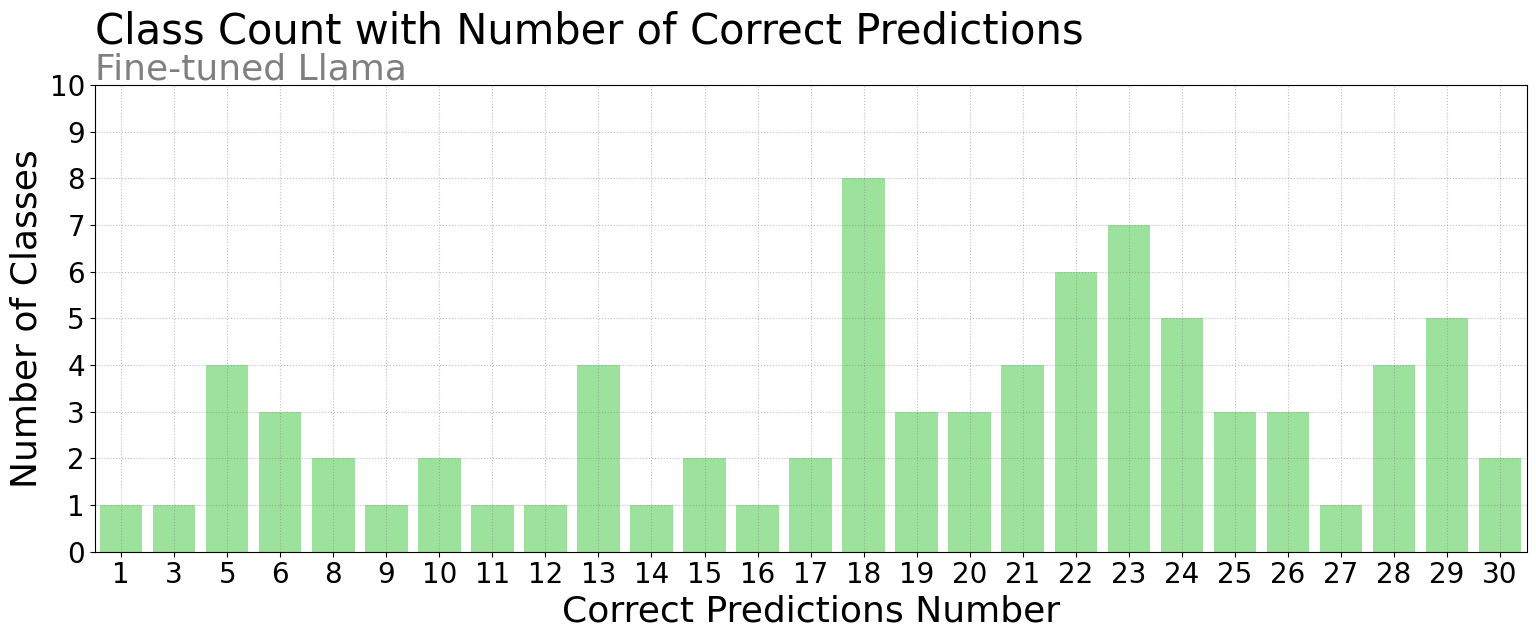

In [36]:
plot_value_counts(
    data,
    'N3 fine_llama Classification',
    title='Class Count with Number of Correct Predictions',
    subtitle='Fine-tuned Llama',
    color='lightgreen',
    ymin=0,
    ymax=11,
    step=1
)

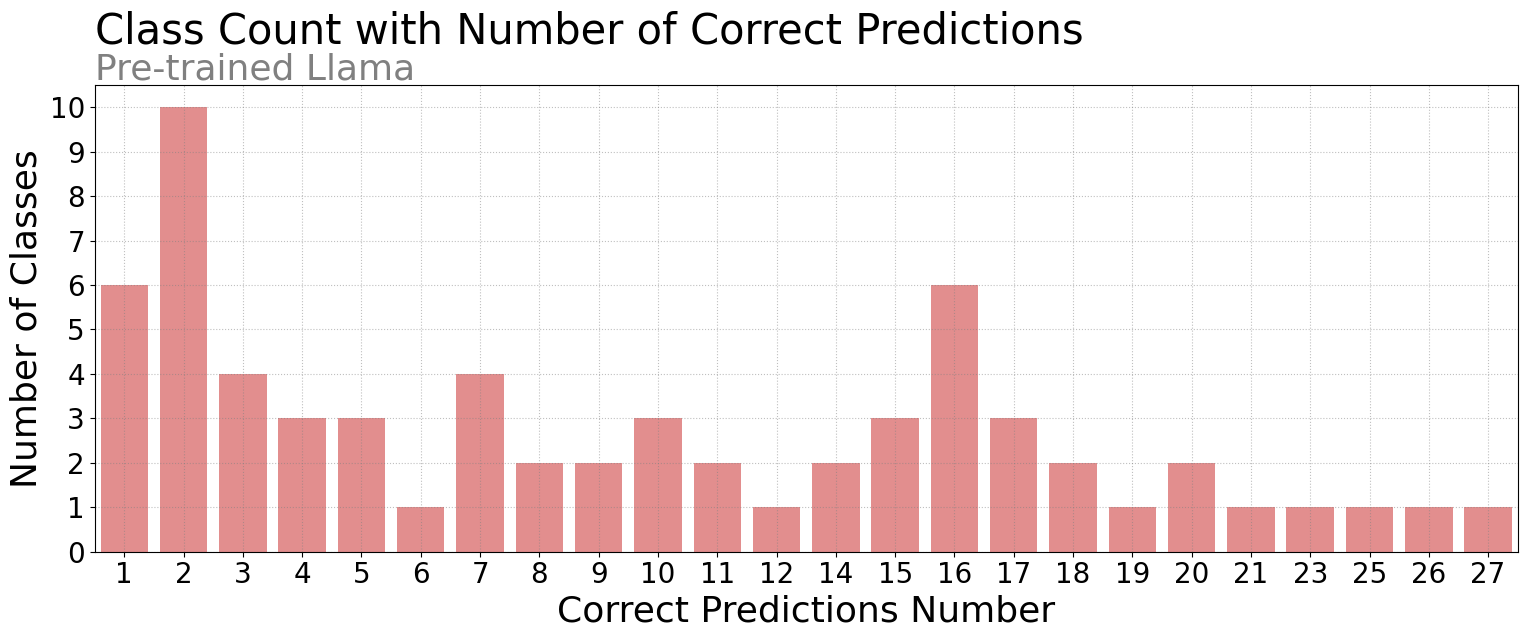

In [37]:
plot_value_counts(
    data,
    'N3 llama Classification',
    title='Class Count with Number of Correct Predictions',
    subtitle='Pre-trained Llama',
    color='lightcoral',
    ymin=0,
    ymax=11,
    step=1
)

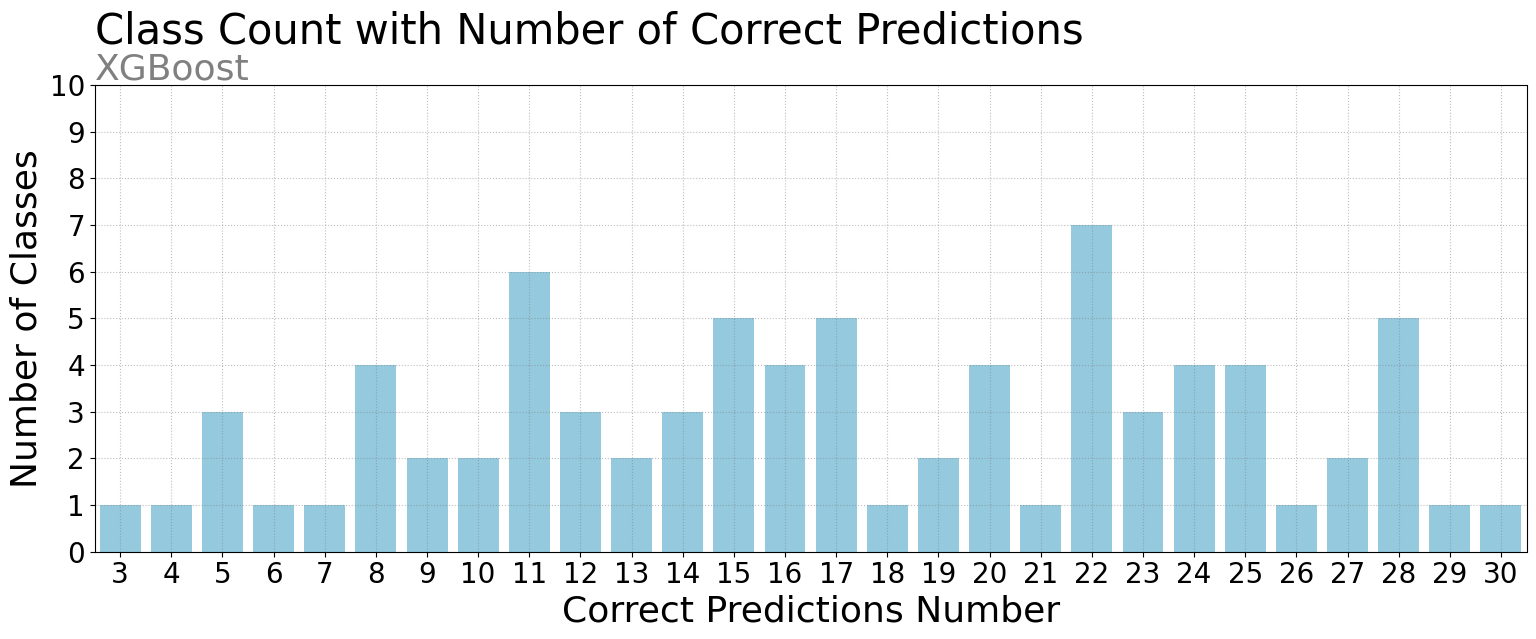

In [38]:
plot_value_counts(
    data,
    'N3 ML Classification',
    title='Class Count with Number of Correct Predictions',
    subtitle='XGBoost',
    color='skyblue',
    ymin=0,
    ymax=11,
    step=1
)

### Confidence Graphs

In [39]:
def mount_dataframe(df, probs, classifs, labels, step=0.025):
    confidences = []
    nivels = []
    types = []
    values = []
    
    for prob, classif, label in zip(probs, classifs, labels):
        for confidence in np.round(np.arange(0, 1 + step, step), 10).tolist():
            filtered = df[df[prob] <= confidence]
            miss_filtered = df[df[prob] > confidence]
            hit = len(filtered[filtered[classif] == filtered[label]])/len(df)
            miss = (len(filtered[filtered[classif] != filtered[label]]) + len(miss_filtered))/len(df)
    
            confidences.append(confidence)
            nivels.append(label.split("_")[1])
            types.append("hit")
            values.append(hit)
    
            confidences.append(confidence)
            nivels.append(label.split("_")[1])
            types.append("miss")
            values.append(miss)
    
    return pd.DataFrame({
        'Confidence': confidences,
        'Nivel': nivels,
        'Type': types,
        'Value': values
    }).sort_values(by=['Type', 'Confidence', 'Nivel']).reset_index(drop=True)

In [72]:
def plot_confidence_lines(df, palette, title, subtitle):
    fig, ax = plt.subplots(figsize=(10,6))
    ax = sns.lineplot(data=df, x='Confidence', y='Value', hue='Nivel', style='Type', markers=True, palette=palette)

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    bbox = ax.get_position()
    fig.text(bbox.x0, 1, title, fontsize=30, color='black', ha='left', va='top')
    fig.text(bbox.x0, 0.93, subtitle, fontsize=26, color='gray', ha='left', va='top')
    
    plt.ylabel('Hit and Miss Taxes', fontsize=24)
    plt.xlabel('Confidence', fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(title='Level / Type', fontsize=16)
    plt.ylim(0, 1)
    ax.grid(True, color='gray', linestyle=':', alpha=0.5, zorder=0)
    plt.show()

In [73]:
def plot_hit_lines(df, palette, title, subtitle):
    fig, ax = plt.subplots(figsize=(10,6))
    ax = sns.lineplot(data=df, x='Confidence', y='Value', hue='Nivel', marker='o', palette=palette)

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    bbox = ax.get_position()
    fig.text(bbox.x0, 1, title, fontsize=30, color='black', ha='left', va='top')
    fig.text(bbox.x0, 0.93, subtitle, fontsize=26, color='gray', ha='left', va='top')
    
    plt.ylabel('Hit and Miss Taxes', fontsize=24)
    plt.xlabel('Confidence', fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(title='Nivel', fontsize=16)
    plt.ylim(0, 1)
    ax.grid(True, color='gray', linestyle=':', alpha=0.5, zorder=0)
    plt.show()

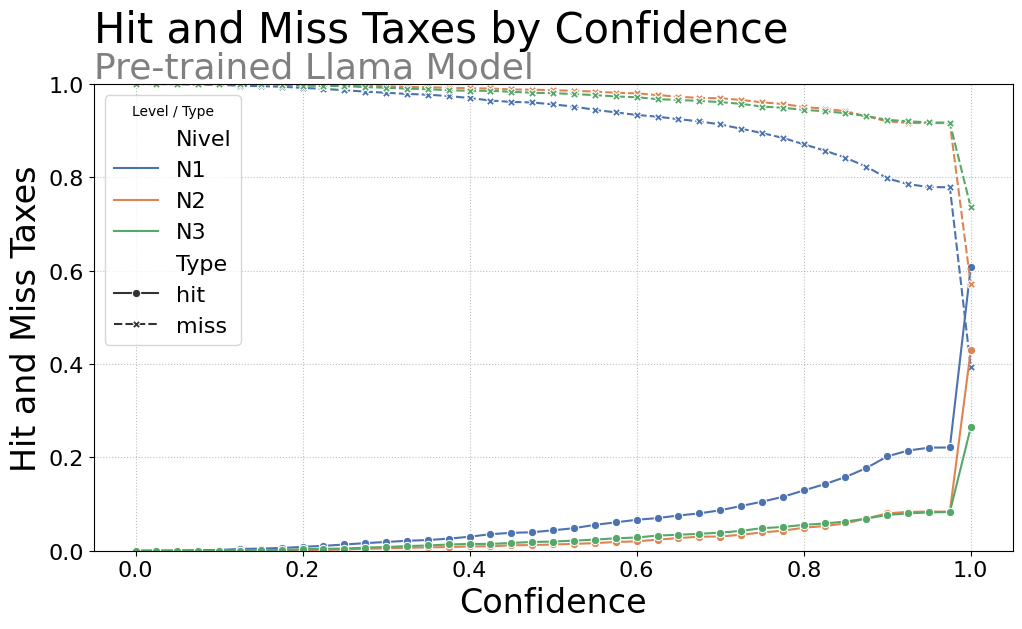

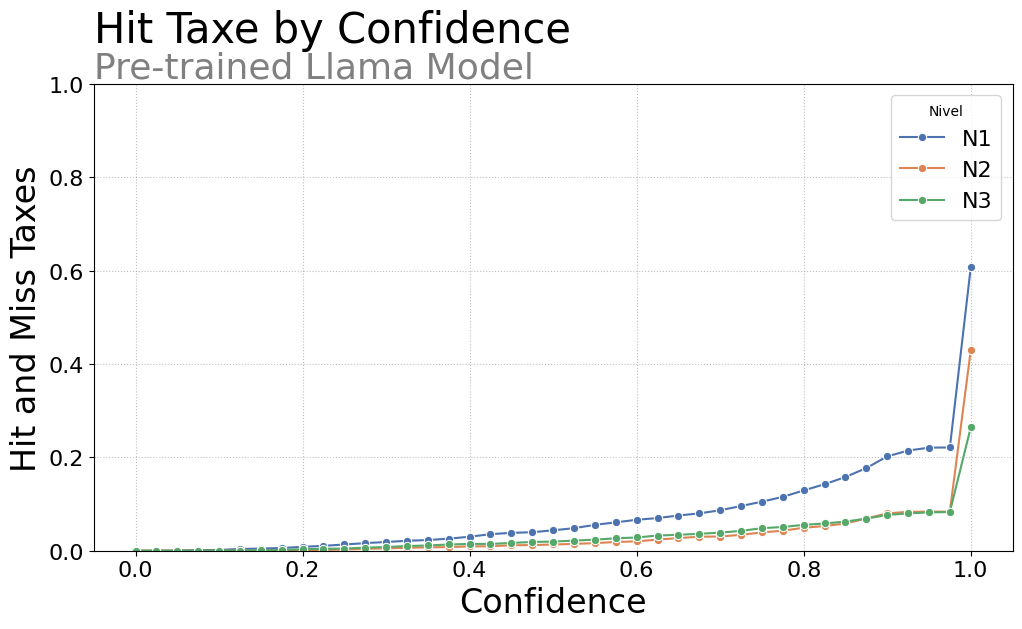

In [74]:
df_hit_miss_llama = mount_dataframe(
    data,
    probs=['N1 llama Pred Proba', 'N2 llama Pred Proba', 'N3 llama Pred Proba'],
    classifs=['N1 llama Classification', 'N2 llama Classification', 'N3 llama Classification'],
    labels=['Label_N1', 'Label_N2', 'Label_N3'],
    step=0.025
)

plot_confidence_lines(
    df=df_hit_miss_llama, 
    palette='deep',
    title='Hit and Miss Taxes by Confidence',
    subtitle='Pre-trained Llama Model'
)

plot_hit_lines(
    df=df_hit_miss_llama[df_hit_miss_llama['Type'] == 'hit'].drop(columns=['Type']), 
    palette='deep',
    title='Hit Taxe by Confidence',
    subtitle='Pre-trained Llama Model'
)

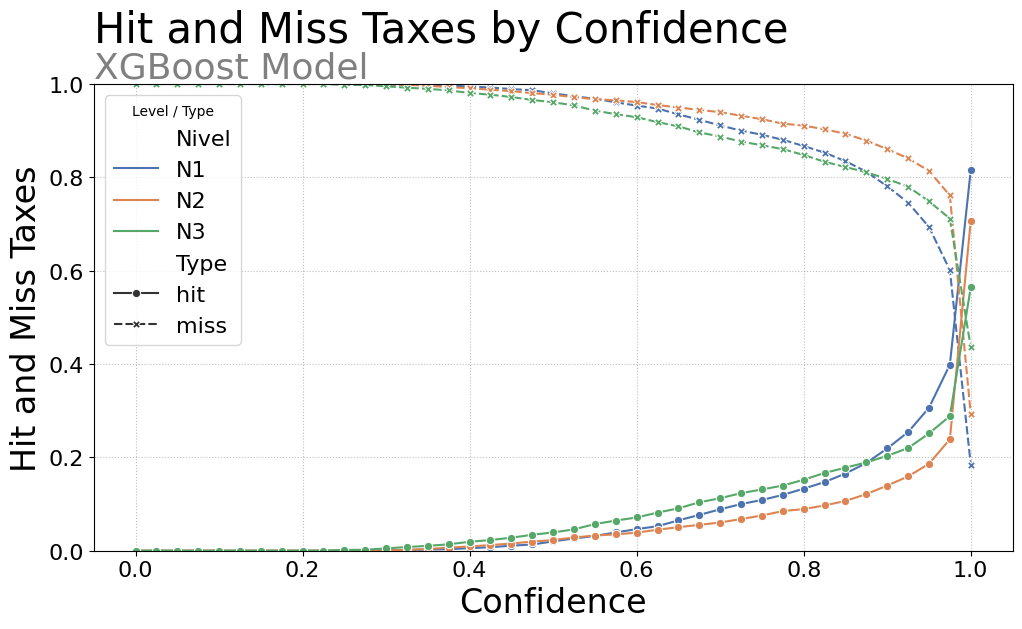

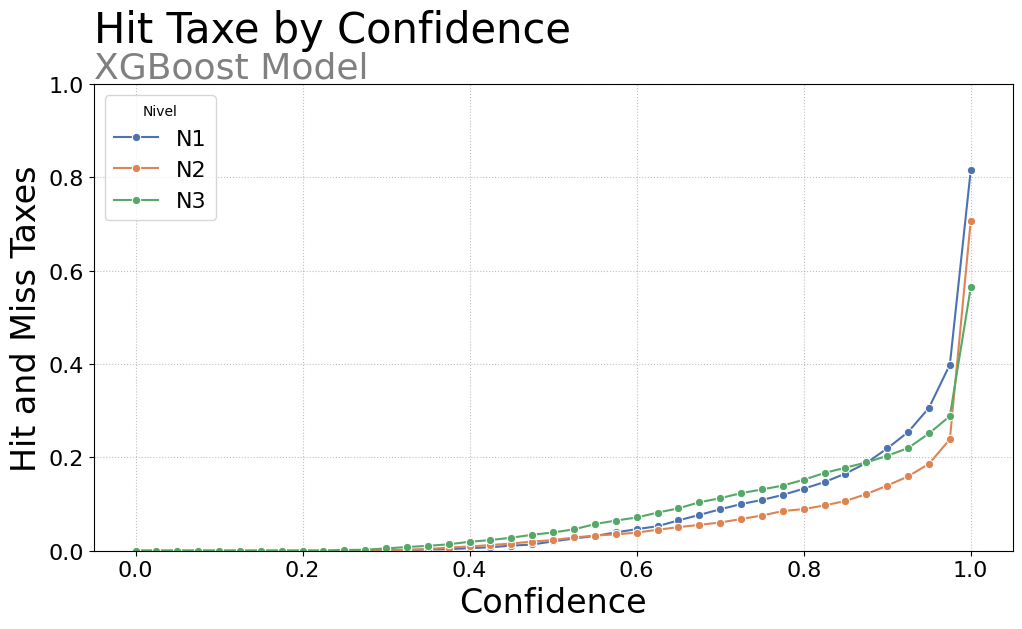

In [75]:
df_hit_miss_ml = mount_dataframe(
    data,
    probs=['N1 Pred Proba', 'N2 Pred Proba', 'N3 Pred Proba'],
    classifs=['N1 ML Classification', 'N2 ML Classification', 'N3 ML Classification'],
    labels=['Label_N1', 'Label_N2', 'Label_N3'],
    step=0.025
)

plot_confidence_lines(
    df=df_hit_miss_ml, 
    palette='deep',
    title='Hit and Miss Taxes by Confidence',
    subtitle='XGBoost Model'
)

plot_hit_lines(
    df=df_hit_miss_ml[df_hit_miss_ml['Type'] == 'hit'].drop(columns=['Type']), 
    palette='deep',
    title='Hit Taxe by Confidence',
    subtitle='XGBoost Model'
)

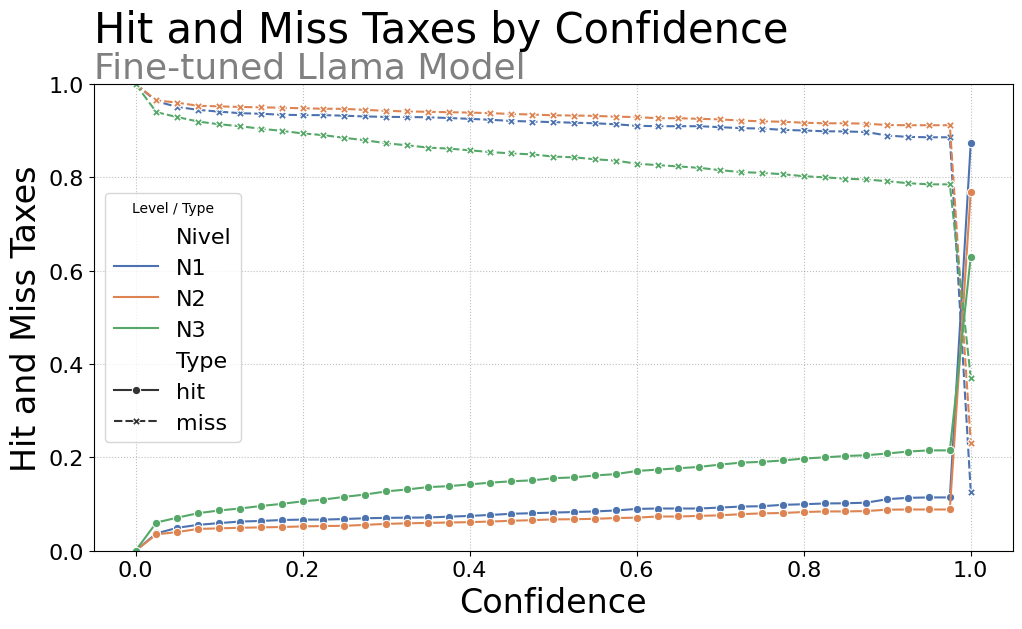

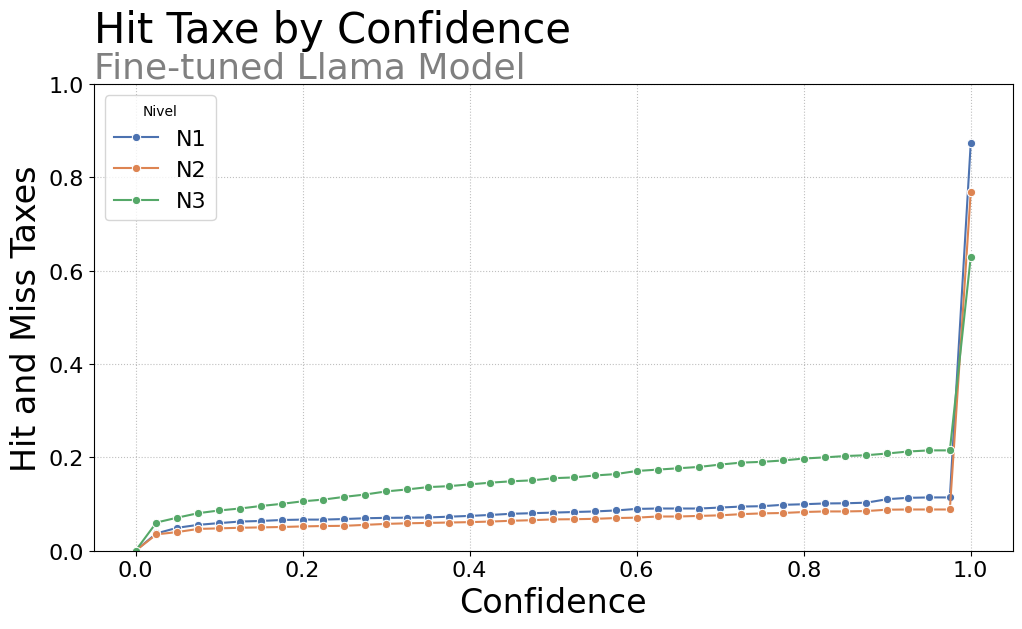

In [76]:
df_hit_miss_fine = mount_dataframe(
    data,
    probs=['N1 fine_llama Pred Proba', 'N2 fine_llama Pred Proba', 'N3 fine_llama Pred Proba'],
    classifs=['N1 fine_llama Classification', 'N2 fine_llama Classification', 'N3 fine_llama Classification'],
    labels=['Label_N1', 'Label_N2', 'Label_N3'],
    step=0.025
)

plot_confidence_lines(
    df=df_hit_miss_fine, 
    palette='deep',
    title='Hit and Miss Taxes by Confidence',
    subtitle='Fine-tuned Llama Model'
)

plot_hit_lines(
    df=df_hit_miss_fine[df_hit_miss_fine['Type'] == 'hit'].drop(columns=['Type']), 
    palette='deep',
    title='Hit Taxe by Confidence',
    subtitle='Fine-tuned Llama Model'
)

### Venns Diagrams

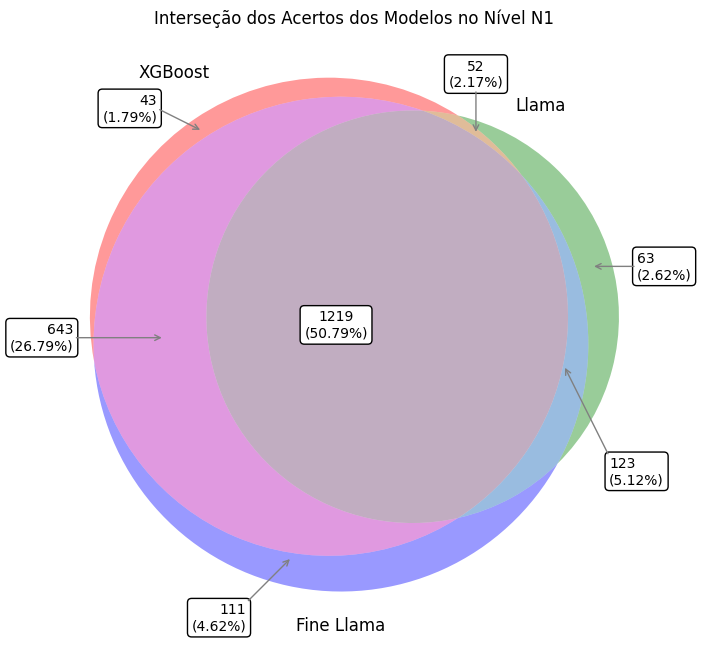

In [195]:
def plot_venn_with_balloons(df, nivel):
    ml_hits = set(df[df[f'{nivel} ML Classification'] == df[f'Label_{nivel}']].index)
    llama_hits = set(df[df[f'{nivel} llama Classification'] == df[f'Label_{nivel}']].index)
    fine_llama_hits = set(df[df[f'{nivel} fine_llama Classification'] == df[f'Label_{nivel}']].index)   

    plt.figure(figsize=(8,8))
    venn = venn3([ml_hits, llama_hits, fine_llama_hits], set_labels=('XGBoost', 'Llama', 'Fine Llama'))

    corrections = {
        '100': (-0.1, 0.05, 'right', 'center'),   # Só XGBoost
        '010': (0.1, 0, 'left', 'center'),   # Só Llama
        '001': (-0.1, -0.1, 'right', 'top'),   # Só Fine Llama
        '110': (0, 0.1, 'center', 'bottom'),   # XGBoost e Llama
        '101': (-0.3, 0, 'right', 'center'),   # XGBoost e Fine Llama
        '011': (0.1, -0.2, 'left', 'top'),   # Llama e Fine Llama
        '111': (0, 0, 'center', 'center'),   # XGBoost, Llama e Fine Llama
    }

    total = len(df)
    for subset in ('100', '010', '001', '110', '101', '011', '111'):
        label = venn.get_label_by_id(subset)
        dst_coords = venn.get_label_by_id(subset).get_position()
        orig_coords = (dst_coords[0] + corrections[subset][0], dst_coords[1] + corrections[subset][1])
        
        if label:
            current = int(label.get_text())
            porcentagem = (current / total) * 100
            value = f"{current}\n({porcentagem:.2f}%)"
            
            label.set_text('')    # Ocultando os rótulos internos

            plt.text(orig_coords[0], orig_coords[1], value, ha=corrections[subset][2], va=corrections[subset][3], fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
            if subset != '101':
                plt.annotate('', xy=dst_coords, xytext=orig_coords, arrowprops=dict(arrowstyle='->', color='gray'))
            else:
                plt.annotate('', xy=(dst_coords[0] - 0.1, dst_coords[1]), xytext=orig_coords, arrowprops=dict(arrowstyle='->', color='gray'))
    
    plt.title(f'Interseção dos Acertos dos Modelos no Nível {nivel}')
    plt.show()

plot_venn_with_balloons(data, 'N1')

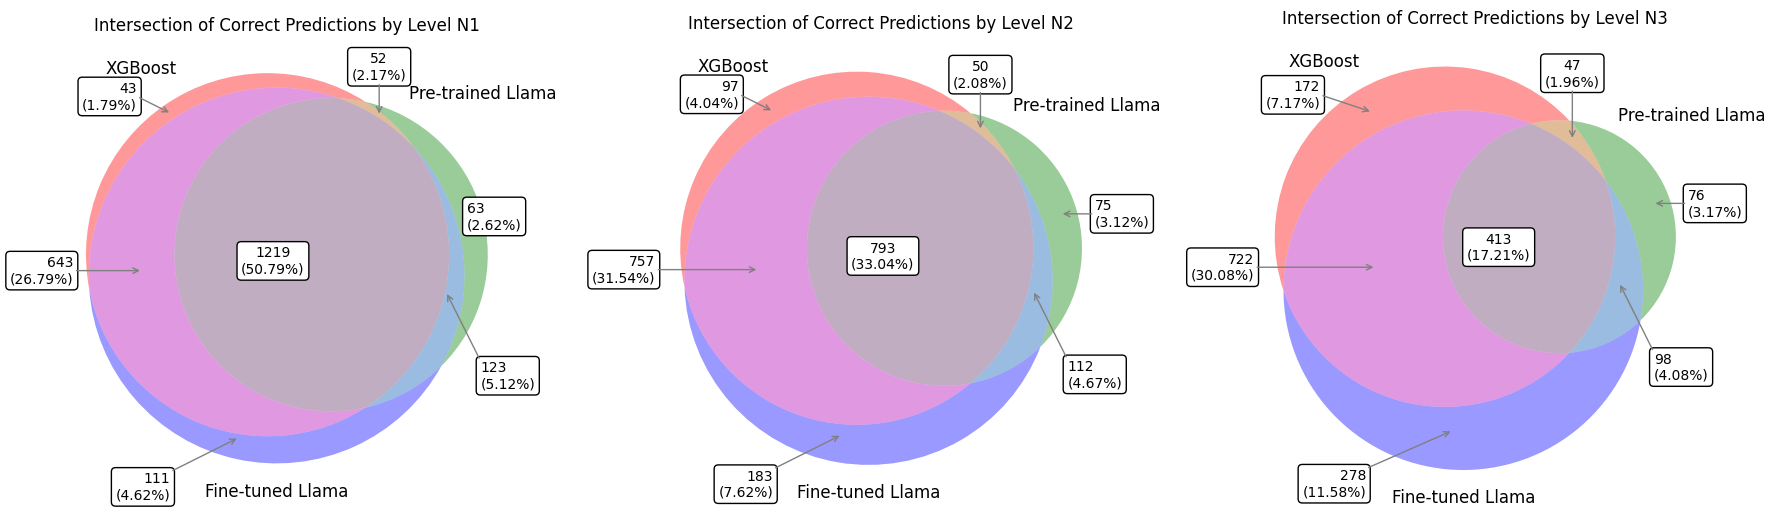

In [13]:
def plot_multi_venns_with_balloons(df):
    fig, axes = plt.subplots(1, 3, figsize=(18,6))

    corrections = {
        'N1': {
            '100': (-0.1, 0.05, 'right', 'center'),   # Só XGBoost
            '010': (0, 0, 'left', 'center'),   # Só Llama
            '001': (-0.2, -0.1, 'right', 'top'),   # Só Fine Llama
            '110': (0, 0.1, 'center', 'bottom'),   # XGBoost e Llama
            '101': (-0.3, 0, 'right', 'center'),   # XGBoost e Fine Llama
            '011': (0.1, -0.2, 'left', 'top'),   # Llama e Fine Llama
            '111': (0, 0, 'center', 'center'),   # XGBoost, Llama e Fine Llama
        },
        'N2': {
            '100': (-0.1, 0.05, 'right', 'center'),   # Só XGBoost
            '010': (0.1, 0, 'left', 'center'),   # Só Llama
            '001': (-0.2, -0.1, 'right', 'top'),   # Só Fine Llama
            '110': (0, 0.12, 'center', 'bottom'),   # XGBoost e Llama
            '101': (-0.4, 0, 'right', 'center'),   # XGBoost e Fine Llama
            '011': (0.1, -0.2, 'left', 'top'),   # Llama e Fine Llama
            '111': (0, 0, 'center', 'center'),   # XGBoost, Llama e Fine Llama
        },
        'N3': {
            '100': (-0.15, 0.05, 'right', 'center'),   # Só XGBoost
            '010': (0.1, 0, 'left', 'center'),   # Só Llama
            '001': (-0.25, -0.11, 'right', 'top'),   # Só Fine Llama
            '110': (0, 0.15, 'center', 'bottom'),   # XGBoost e Llama
            '101': (-0.45, 0, 'right', 'center'),   # XGBoost e Fine Llama
            '011': (0.1, -0.2, 'left', 'top'),   # Llama e Fine Llama
            '111': (0, 0, 'center', 'center'),   # XGBoost, Llama e Fine Llama
        }
    }
    
    for ax, nivel in zip(axes, ['N1', 'N2', 'N3']):
        ml_hits = set(df[df[f'{nivel} ML Classification'] == df[f'Label_{nivel}']].index)
        llama_hits = set(df[df[f'{nivel} llama Classification'] == df[f'Label_{nivel}']].index)
        fine_llama_hits = set(df[df[f'{nivel} fine_llama Classification'] == df[f'Label_{nivel}']].index)

        plt.sca(ax)

        venn = venn3([ml_hits, llama_hits, fine_llama_hits], set_labels=('XGBoost', 'Pre-trained Llama', 'Fine-tuned Llama'), ax=ax)
        ax.set_title(f'Intersection of Correct Predictions by Level {nivel}')

        total = len(df)
        for subset in ('100', '010', '001', '110', '101', '011', '111'):
            label = venn.get_label_by_id(subset)
            dst_coords = venn.get_label_by_id(subset).get_position()
            orig_coords = (dst_coords[0] + corrections[nivel][subset][0], dst_coords[1] + corrections[nivel][subset][1])
        
            if label:
                current = int(label.get_text())
                porcentagem = (current / total) * 100
                value = f"{current}\n({porcentagem:.2f}%)"
            
                label.set_text('')    # Ocultando os rótulos internos

                plt.text(orig_coords[0], orig_coords[1], value, ha=corrections[nivel][subset][2], va=corrections[nivel][subset][3], fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
                if subset == '101':
                    plt.annotate('', xy=(dst_coords[0] - 0.1, dst_coords[1]), xytext=orig_coords, arrowprops=dict(arrowstyle='->', color='gray'))
                else:
                    plt.annotate('', xy=dst_coords, xytext=orig_coords, arrowprops=dict(arrowstyle='->', color='gray'))
        
    plt.tight_layout()
    plt.show()

plot_multi_venns_with_balloons(data)

### Collaboration Graphs

In [98]:
def plot_colaboration(df, title, subtitle, ymin, ymax):
    bar_width = 0.4
    positive_values = df[df['Valor'] >= 0]
    negative_values = df[df['Valor'] < 0]
    
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.bar(positive_values['Junção'], positive_values['Valor'], width=bar_width, color='skyblue', label='Collaboration')
    ax.bar(negative_values['Junção'], negative_values['Valor'], width=bar_width, color='salmon', label='Perturbation')
    ax.axhline(0, color='black', linewidth=0.8)

    ax.set_xticks(positive_values['Junção'])
    ax.set_xticklabels(positive_values['Atributo'])
    ax.legend(fontsize=16)
    
    for bar in ax.containers:
        ax.bar_label(bar, fmt='%.f', padding=3, fontsize=16, color='gray')
    
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    bbox = ax.get_position()
    fig.text(bbox.x0, 1.05, title, fontsize=30, color='black', ha='left', va='top')
    fig.text(bbox.x0, 0.94, subtitle, fontsize=26, color='gray', ha='left', va='top')
    
    plt.xlabel('Collaborations', fontsize=24)
    plt.ylabel('Count', fontsize=24)
    plt.xticks(rotation=90, fontsize=16) 
    plt.yticks(fontsize=16) 
    plt.ylim(ymin, ymax)
    ax.grid(True, color='gray', linestyle=':', alpha=0.5, zorder=0)
    plt.show()

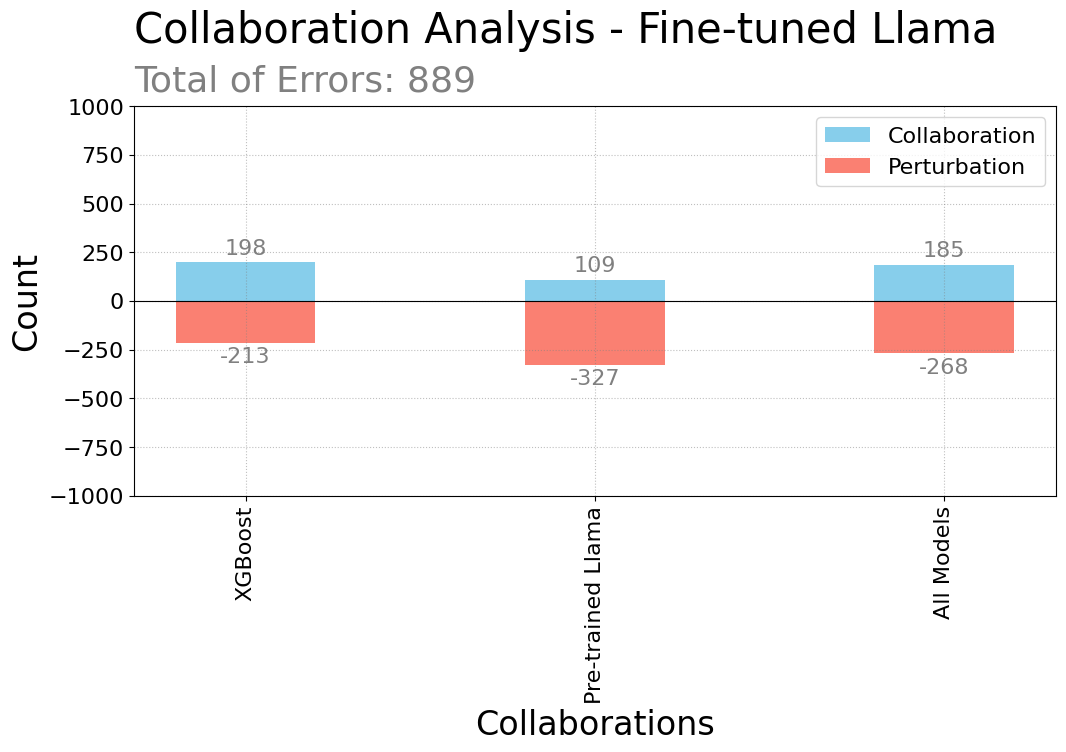

In [100]:
erros = data[data['N3 fine_llama Classification'] != data['Label_N3']]
correcoes_ML_fine_llama = erros[erros['ML + Fine Llama'] == erros['Label_N3']].shape[0]
correcoes_llama_fine_llama = erros[erros['Llama + Fine Llama'] == erros['Label_N3']].shape[0]
correcoes_joint = erros[erros['Joint Classification'] == erros['Label_N3']].shape[0]

acertos = data[data['N3 fine_llama Classification'] == data['Label_N3']]
perturbacao_ML_fine_llama = acertos[acertos['ML + Fine Llama'] != acertos['Label_N3']].shape[0]
perturbacao_llama_fine_llama = acertos[acertos['Llama + Fine Llama'] != acertos['Label_N3']].shape[0]
perturbacao_joint = acertos[acertos['Joint Classification'] != acertos['Label_N3']].shape[0]

df_fine_llama = pd.DataFrame(
    {
        'Atributo': [
            # 'Total de Erros Fine Llama',
            'XGBoost',
            'Pre-trained Llama',
            'All Models',
            'XGBoost',
            'Pre-trained Llama',
            'All Models'
        ],
        'Valor': [
            # erros.shape[0],
            correcoes_ML_fine_llama,
            correcoes_llama_fine_llama,
            correcoes_joint,
            -perturbacao_ML_fine_llama,
            -perturbacao_llama_fine_llama,
            -perturbacao_joint
        ],
        'Junção': [0, 1, 2, 0, 1, 2]
    }
)

plot_colaboration(
    df=df_fine_llama, 
    title="Collaboration Analysis - Fine-tuned Llama", 
    subtitle=f'Total of Errors: {erros.shape[0]}',
    ymin=-1000,
    ymax=1000
)

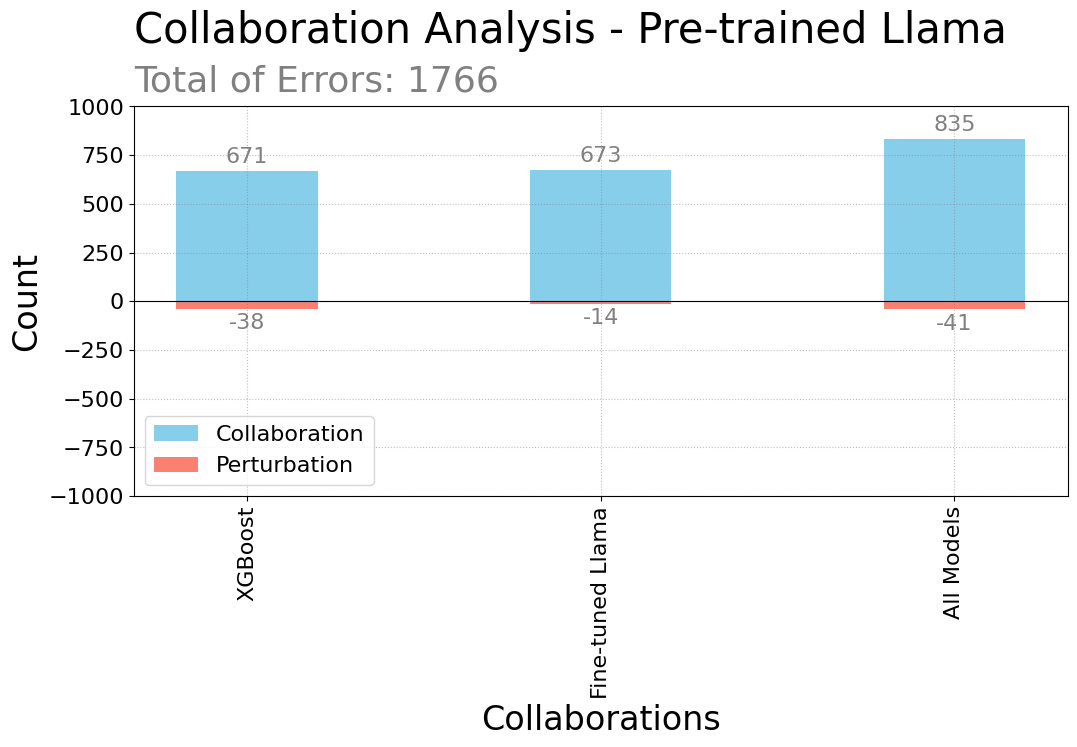

In [101]:
erros = data[data['N3 llama Classification'] != data['Label_N3']]
correcoes_ML_llama = erros[erros['ML + Llama'] == erros['Label_N3']].shape[0]
correcoes_llama_fine_llama = erros[erros['Llama + Fine Llama'] == erros['Label_N3']].shape[0]
correcoes_joint = erros[erros['Joint Classification'] == erros['Label_N3']].shape[0]

acertos = data[data['N3 llama Classification'] == data['Label_N3']]
perturbacao_ML_llama = acertos[acertos['ML + Llama'] != acertos['Label_N3']].shape[0]
perturbacao_llama_fine_llama = acertos[acertos['Llama + Fine Llama'] != acertos['Label_N3']].shape[0]
perturbacao_joint = acertos[acertos['Joint Classification'] != acertos['Label_N3']].shape[0]

df_llama = pd.DataFrame(
    {
        'Atributo': [
            # 'Total de Erros Fine Llama',
            'XGBoost',
            'Fine-tuned Llama',
            'All Models',
            'XGBoost',
            'Fine-tuned Llama',
            'All Models'
        ],
        'Valor': [
            # erros.shape[0],
            correcoes_ML_llama,
            correcoes_llama_fine_llama,
            correcoes_joint,
            -perturbacao_ML_llama,
            -perturbacao_llama_fine_llama,
            -perturbacao_joint
        ],
        'Junção': [0, 1, 2, 0, 1, 2]
    }
)

plot_colaboration(
    df=df_llama, 
    title="Collaboration Analysis - Pre-trained Llama", 
    subtitle=f'Total of Errors: {erros.shape[0]}',
    ymin=-1000,
    ymax=1000
)

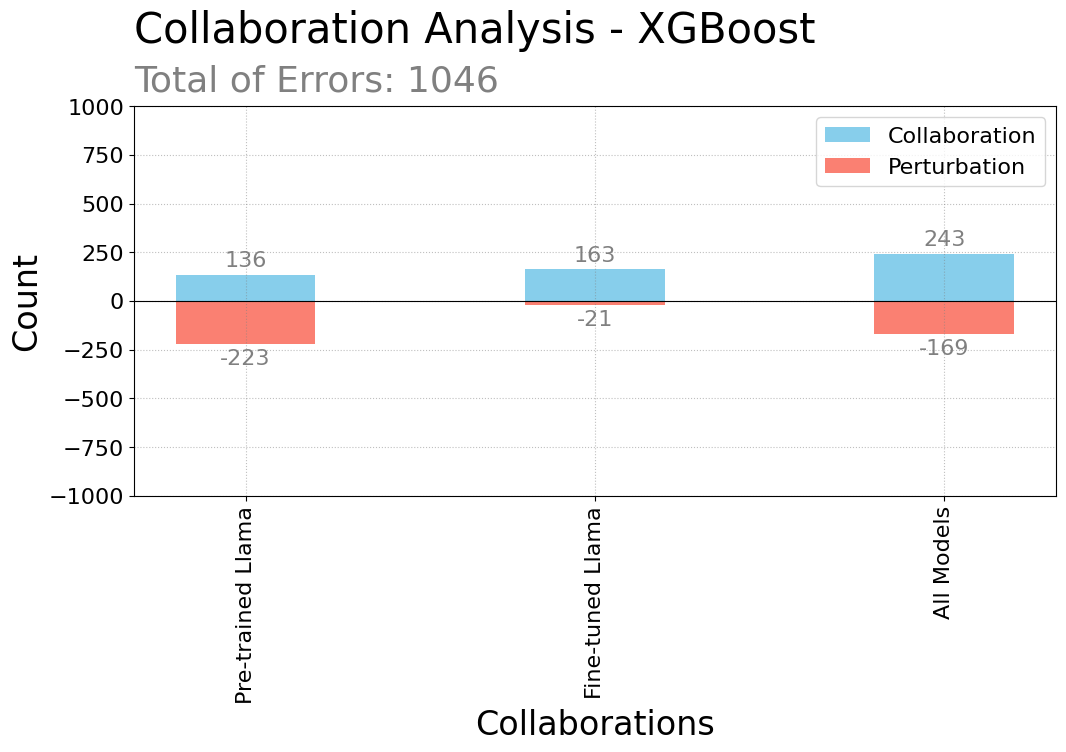

In [102]:
erros = data[data['N3 ML Classification'] != data['Label_N3']]
correcoes_ML_llama = erros[erros['ML + Llama'] == erros['Label_N3']].shape[0]
correcoes_ML_fine_llama = erros[erros['ML + Fine Llama'] == erros['Label_N3']].shape[0]
correcoes_joint = erros[erros['Joint Classification'] == erros['Label_N3']].shape[0]

acertos = data[data['N3 ML Classification'] == data['Label_N3']]
perturbacao_ML_llama = acertos[acertos['ML + Llama'] != acertos['Label_N3']].shape[0]
perturbacao_ML_fine_llama = acertos[acertos['ML + Fine Llama'] != acertos['Label_N3']].shape[0]
perturbacao_joint = acertos[acertos['Joint Classification'] != acertos['Label_N3']].shape[0]

df_llama = pd.DataFrame(
    {
        'Atributo': [
            # 'Total de Erros Fine Llama',
            'Pre-trained Llama',
            'Fine-tuned Llama',
            'All Models',
            'Pre-trained Llama',
            'Fine-tuned Llama',
            'All Models'
        ],
        'Valor': [
            # erros.shape[0],
            correcoes_ML_llama,
            correcoes_ML_fine_llama,
            correcoes_joint,
            -perturbacao_ML_llama,
            -perturbacao_ML_fine_llama,
            -perturbacao_joint
        ],
        'Junção': [0, 1, 2, 0, 1, 2]
    }
)

plot_colaboration(
    df=df_llama, 
    title="Collaboration Analysis - XGBoost", 
    subtitle=f'Total of Errors: {erros.shape[0]}',
    ymin=-1000,
    ymax=1000
)